In [1]:
import pandas as pd
from pathlib import Path
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import urllib
import zipfile
import geopandas as gpd
import seaborn as sns
import shapely.geometry
from shapely.geometry import Point, Polygon
import libpysal as lps
from libpysal.weights import Queen, Rook, KNN
import pysal as ps
import spreg
import mgwr
import mapclassify
import pysal.viz as viz
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
from shapely.wkt import loads 
from shapely import wkt
from libpysal import weights
#handle warnings
import warnings
warnings.filterwarnings("ignore")

# Graphics
from matplotlib import colors

# Analysis
import statsmodels.formula.api as smf
from pysal.model import spreg
from libpysal import weights
from pysal.explore import esda

C:\Users\josh1\anaconda3\envs\sds2023\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\josh1\anaconda3\envs\sds2023\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\josh1\anaconda3\envs\sds2023\lib\site-pack

In [2]:
crime_ipath = Path("../data/Crime/")
historic_fp = crime_ipath/"MPS LSOA Level Crime (Historical).csv"
recent_fp = crime_ipath/"crime in 2021.csv"
historic_df = pd.read_csv(historic_fp)
recent_df = pd.read_csv(recent_fp)

In [3]:
### get average crime rate of each place 
to_exclude = ['LSOA Code',
             'LSOA Name',
             'Borough',
             'Major Category',
             'Minor Category']

all_dates = [var_name for var_name in historic_df.columns if var_name not in to_exclude]
all_dates = [var_name for var_name in recent_df.columns if var_name not in to_exclude]

In [4]:
## compute summary stats across time 

#only count 2011 and 2021
dates2011 = [date for date in historic_df.columns if '2011' in date]
dates2021 = [date for date in recent_df.columns if '2021' in date]
historic_df['crime2011'] = historic_df[dates2011].sum(axis=1)
recent_df['crime2021'] = recent_df[dates2021].sum(axis=1)

#historic_df['sample_average_crime'] = historic_df[all_dates].mean(axis=1) ## or use median or sum 
#current_df['sample_average_crime'] =historic_df[all_dates].mean(axis=1)

historic_df = historic_df[['LSOA Code','LSOA Name','Borough','Major Category','Minor Category','crime2011']]
recent_df = recent_df[['LSOA Code','LSOA Name','Borough','Major Category','Minor Category','crime2021']]
historic_df.dtypes

LSOA Code         object
LSOA Name         object
Borough           object
Major Category    object
Minor Category    object
crime2011          int64
dtype: object

In [5]:
recent_df.dtypes

LSOA Code          object
LSOA Name          object
Borough            object
Major Category     object
Minor Category     object
crime2021         float64
dtype: object

In [6]:
## reshape the data in 2011
historic_df['crime_type'] = historic_df['Major Category']+': '+historic_df['Minor Category']

rehistoric_df = pd.pivot(historic_df, 
                       index=['LSOA Code', 'LSOA Name', 'Borough'], 
                       columns='crime_type', 
                       values='crime2011')

rehistoric_df =rehistoric_df.reset_index()
rehistoric_df

crime_type  LSOA Code                  LSOA Name               Borough  \
0           E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1           E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2           E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3           E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4           E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...               ...                        ...                   ...   
4824        E01033742             Greenwich 007F             Greenwich   
4825        E01033743             Greenwich 002H             Greenwich   
4826        E01033744             Greenwich 007G             Greenwich   
4827        E01033745             Greenwich 002I             Greenwich   
4828        E01033746             Greenwich 038E             Greenwich   

crime_type  Arson and Criminal Damage: Arson  \
0                                        0.0   
1                                        2.0   
2                                        1.0   
3                                        3.0   
4                                        3.0   
...                                      ...   
4824                                     1.0   
4825                                     1.0   
4826                                     2.0   
4827                                     1.0   
4828                                     1.0   

crime_type  Arson and Criminal Damage: Criminal Damage  \
0                                                  4.0   
1                                                 39.0   
2                                                 14.0   
3                                                 34.0   
4                                                 69.0   
...                                                ...   
4824                                               9.0   
4825                                              22.0   
4826                                              12.0   
4827                                              22.0   
4828                                              11.0   

crime_type  Burglary: Burglary Business and Community  \
0                                                 1.0   
1                                                 5.0   
2                                                 4.0   
3                                                 9.0   
4                                                33.0   
...                                               ...   
4824                                              1.0   
4825                                              3.0   
4826                                              5.0   
4827                                              4.0   
4828                                              4.0   

crime_type  Burglary: Domestic Burglary  Drug Offences: Drug Trafficking  \
0                                  21.0                              1.0   
1                                   8.0                              2.0   
2                                   9.0                              2.0   
3                                  14.0                              2.0   
4                                  18.0                              0.0   
...                                 ...                              ...   
4824                                5.0                              0.0   
4825                                3.0                              1.0   
4826                                8.0                              0.0   
4827                                7.0                              1.0   
4828                               17.0                              0.0   

crime_type  Drug Offences: Possession of Drugs  \
0                                          9.0   
1                                         50.0   
2                                         18.0   
3                                      

In [7]:
## reshape the data in 2021
recent_df['crime_type'] = recent_df['Major Category']+': '+recent_df['Minor Category']

rerecent_df = pd.pivot(recent_df, 
                       index=['LSOA Code', 'LSOA Name', 'Borough'], 
                       columns='crime_type', 
                       values='crime2021')

rerecent_df =rerecent_df.reset_index()
rerecent_df

crime_type  LSOA Code                  LSOA Name               Borough  \
0           E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1           E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2           E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3           E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4           E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...               ...                        ...                   ...   
4824        E01033742             Greenwich 007F             Greenwich   
4825        E01033743             Greenwich 002H             Greenwich   
4826        E01033744             Greenwich 007G             Greenwich   
4827        E01033745             Greenwich 002I             Greenwich   
4828        E01033746             Greenwich 038E             Greenwich   

crime_type  Arson and Criminal Damage: Arson  \
0                                        3.0   
1                                        1.0   
2                                        1.0   
3                                       70.0   
4                                        0.0   
...                                      ...   
4824                                     0.0   
4825                                     1.0   
4826                                     1.0   
4827                                     0.0   
4828                                     0.0   

crime_type  Arson and Criminal Damage: Criminal Damage  \
0                                                  3.0   
1                                                  4.0   
2                                                  8.0   
3                                                 23.0   
4                                                  7.0   
...                                                ...   
4824                                               0.0   
4825                                               6.0   
4826                                               0.0   
4827                                               0.0   
4828                                               0.0   

crime_type  Burglary: Burglary Business and Community  \
0                                                 3.0   
1                                                 1.0   
2                                                 3.0   
3                                                13.0   
4                                                 4.0   
...                                               ...   
4824                                              0.0   
4825                                              0.0   
4826                                              0.0   
4827                                              0.0   
4828                                              0.0   

crime_type  Burglary: Domestic Burglary  Drug Offences: Drug Trafficking  \
0                                  11.0                              1.0   
1                                   2.0                              1.0   
2                                  31.0                              8.0   
3                                   0.0                             85.0   
4                                   5.0                              3.0   
...                                 ...                              ...   
4824                                0.0                              0.0   
4825                                0.0                              0.0   
4826                                3.0                              0.0   
4827                                0.0                              0.0   
4828                                1.0                              0.0   

crime_type  Drug Offences: Possession of Drugs  \
0                                          5.0   
1                                         15.0   
2                                          8.0   
3                                      

In [8]:
## count total crime of all types in 2011 

all_crime = [crime for crime in list(rehistoric_df.columns) if crime not in ['LSOA Code','LSOA Name','Borough']]

rehistoric_df['all_crime_2011'] = rehistoric_df[all_crime].sum(axis=1, numeric_only=True)
rehistoric_df2 = rehistoric_df[['LSOA Code','LSOA Name','Borough','all_crime_2011']]
rehistoric_df2

crime_type  LSOA Code                  LSOA Name               Borough  \
0           E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1           E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2           E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3           E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4           E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...               ...                        ...                   ...   
4824        E01033742             Greenwich 007F             Greenwich   
4825        E01033743             Greenwich 002H             Greenwich   
4826        E01033744             Greenwich 007G             Greenwich   
4827        E01033745             Greenwich 002I             Greenwich   
4828        E01033746             Greenwich 038E             Greenwich   

crime_type  all_crime_2011  
0                    109.0  
1                    426.0  
2                    179.0  
3                    351.0  
4                   1202.0  
...                    ...  
4824                  65.0  
4825                 301.0  
4826                  95.0  
4827                 133.0  
4828                  87.0  

[4829 rows x 4 columns]

In [9]:
## count total crime of all types in 2021 
all_crime_1 = [crime for crime in list(rerecent_df.columns) if crime not in ['LSOA Code','LSOA Name','Borough']]
rerecent_df['all_crime_2021'] = rerecent_df[all_crime_1].sum(axis=1, numeric_only=True)
rerecent_df2 = rerecent_df[['LSOA Code','LSOA Name','Borough','all_crime_2021']]
rerecent_df2

crime_type  LSOA Code                  LSOA Name               Borough  \
0           E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1           E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2           E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3           E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4           E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...               ...                        ...                   ...   
4824        E01033742             Greenwich 007F             Greenwich   
4825        E01033743             Greenwich 002H             Greenwich   
4826        E01033744             Greenwich 007G             Greenwich   
4827        E01033745             Greenwich 002I             Greenwich   
4828        E01033746             Greenwich 038E             Greenwich   

crime_type  all_crime_2021  
0                    220.0  
1                    426.0  
2                    410.0  
3                   1112.0  
4                    477.0  
...                    ...  
4824                  12.0  
4825                  68.0  
4826                  35.0  
4827                  17.0  
4828                   8.0  

[4829 rows x 4 columns]

In [10]:
#only shows the property crime in dataset
#2011
historic_dfp = historic_df[(historic_df['Major Category'] == 'Burglary') | (historic_df['Major Category'] == 'Theft') | (historic_df['Major Category'] == 'Robbery')]
#sum the data
new_df = historic_dfp.groupby('LSOA Code')['crime2011'].sum().reset_index()
new_df = new_df.rename(columns={'crime2011': 'PropertyCrime_11'})
new_df


LSOA Code  PropertyCrime_11
0     E01000006                43
1     E01000007               135
2     E01000008                61
3     E01000009               109
4     E01000010               654
...         ...               ...
4824  E01033742                23
4825  E01033743               183
4826  E01033744                31
4827  E01033745                46
4828  E01033746                52

[4829 rows x 2 columns]

In [11]:
#only shows the property crime in dataset
#2021
recent_dfp = recent_df[(recent_df['Major Category'] == 'Burglary') | (recent_df['Major Category'] == 'Theft') | (recent_df['Major Category'] == 'Robbery')]
#sum the data
new_df_1 = recent_dfp.groupby('LSOA Code')['crime2021'].sum().reset_index()
new_df_1 = new_df_1.rename(columns={'crime2021': 'PropertyCrime_21'})
new_df_1

LSOA Code  PropertyCrime_21
0     E01000006              36.0
1     E01000007              54.0
2     E01000008             101.0
3     E01000009             304.0
4     E01000010             183.0
...         ...               ...
4824  E01033742               3.0
4825  E01033743              34.0
4826  E01033744               7.0
4827  E01033745               4.0
4828  E01033746               1.0

[4829 rows x 2 columns]

In [12]:
#merge the 2011 property data into the orginal data
rehistoric_df3 = pd.merge(rehistoric_df,
                    new_df,
                   left_on ='LSOA Code',
                   right_on='LSOA Code',
                   how='inner')
rehistoric_df3

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      Arson and Criminal Damage: Arson  \
0                                  0.0   
1                                  2.0   
2                                  1.0   
3                                  3.0   
4                                  3.0   
...                                ...   
4824                               1.0   
4825                               1.0   
4826                               2.0   
4827                               1.0   
4828                               1.0   

      Arson and Criminal Damage: Criminal Damage  \
0                                            4.0   
1                                           39.0   
2                                           14.0   
3                                           34.0   
4                                           69.0   
...                                          ...   
4824                                         9.0   
4825                                        22.0   
4826                                        12.0   
4827                                        22.0   
4828                                        11.0   

      Burglary: Burglary Business and Community  Burglary: Domestic Burglary  \
0                                           1.0                         21.0   
1                                           5.0                          8.0   
2                                           4.0                          9.0   
3                                           9.0                         14.0   
4                                          33.0                         18.0   
...                                         ...                          ...   
4824                                        1.0                          5.0   
4825                                        3.0                          3.0   
4826                                        5.0                          8.0   
4827                                        4.0                          7.0   
4828                                        4.0                         17.0   

      Drug Offences: Drug Trafficking  Drug Offences: Possession of Drugs  \
0                                 1.0                                 9.0   
1                                 2.0                                50.0   
2                                 2.0                                18.0   
3                                 2.0                                54.0   
4                                 0.0                               102.0   
...                               ...                                 ...   
4824                              0.0                                 2.0   
4825                              1.0                                 8.0   
4826                              0.0                                 3.0   
4827                              1.0                                 2.0   
4828                              0.0                                 0.0   

      Miscellaneous Crimes Against Society: Absconding from Lawful Custody  \
0                                                   NaN                      
1                

In [13]:
#merge the 2021 property data into the orginal data
rerecent_df3 = pd.merge(rerecent_df,
                    new_df_1,
                   left_on ='LSOA Code',
                   right_on='LSOA Code',
                   how='inner')
rerecent_df3

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      Arson and Criminal Damage: Arson  \
0                                  3.0   
1                                  1.0   
2                                  1.0   
3                                 70.0   
4                                  0.0   
...                                ...   
4824                               0.0   
4825                               1.0   
4826                               1.0   
4827                               0.0   
4828                               0.0   

      Arson and Criminal Damage: Criminal Damage  \
0                                            3.0   
1                                            4.0   
2                                            8.0   
3                                           23.0   
4                                            7.0   
...                                          ...   
4824                                         0.0   
4825                                         6.0   
4826                                         0.0   
4827                                         0.0   
4828                                         0.0   

      Burglary: Burglary Business and Community  Burglary: Domestic Burglary  \
0                                           3.0                         11.0   
1                                           1.0                          2.0   
2                                           3.0                         31.0   
3                                          13.0                          0.0   
4                                           4.0                          5.0   
...                                         ...                          ...   
4824                                        0.0                          0.0   
4825                                        0.0                          0.0   
4826                                        0.0                          3.0   
4827                                        0.0                          0.0   
4828                                        0.0                          1.0   

      Drug Offences: Drug Trafficking  Drug Offences: Possession of Drugs  \
0                                 1.0                                 5.0   
1                                 1.0                                15.0   
2                                 8.0                                 8.0   
3                                85.0                                 8.0   
4                                 3.0                                43.0   
...                               ...                                 ...   
4824                              0.0                                 3.0   
4825                              0.0                                 6.0   
4826                              0.0                                 3.0   
4827                              0.0                                 0.0   
4828                              0.0                                 1.0   

      Miscellaneous Crimes Against Society: Absconding from Lawful Custody  \
0                                                   NaN                      
1                

In [14]:
#only shows the 2011 antisocial behaviour crime in dataset
historic_dfa = historic_df[(historic_df['Major Category'] == 'Drug Offences') | (historic_df['Major Category'] == 'Miscellaneous Crimes Against Society') | (historic_df['Major Category'] == 'Public Order Offences')]
#sum the data
new_df11 = historic_dfa.groupby('LSOA Code')['crime2011'].sum().reset_index()
new_df11 = new_df11.rename(columns={'crime2011': 'antiCrime_11'})
new_df11

LSOA Code  antiCrime_11
0     E01000006            14
1     E01000007            89
2     E01000008            30
3     E01000009            77
4     E01000010           186
...         ...           ...
4824  E01033742             7
4825  E01033743            18
4826  E01033744             7
4827  E01033745            12
4828  E01033746             1

[4829 rows x 2 columns]

In [15]:
#only shows the 2021 antisocial behaviour crime in dataset
recent_dfa = recent_df[(recent_df['Major Category'] == 'Drug Offences') | (recent_df['Major Category'] == 'Miscellaneous Crimes Against Society') | (recent_df['Major Category'] == 'Public Order Offences')]
#sum the data
new_df21 = recent_dfa.groupby('LSOA Code')['crime2021'].sum().reset_index()
new_df21 = new_df21.rename(columns={'crime2021': 'antiCrime_21'})
new_df21

LSOA Code  antiCrime_21
0     E01000006          26.0
1     E01000007         268.0
2     E01000008         200.0
3     E01000009         472.0
4     E01000010         137.0
...         ...           ...
4824  E01033742           4.0
4825  E01033743          10.0
4826  E01033744           6.0
4827  E01033745           6.0
4828  E01033746           3.0

[4829 rows x 2 columns]

In [16]:
#merge the 2011 antisocial behaviour crime data into the orginal data
rehistoric_df4 = pd.merge(rehistoric_df3,
                    new_df11,
                   left_on ='LSOA Code',
                   right_on='LSOA Code',
                   how='inner')
rehistoric_df4

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      Arson and Criminal Damage: Arson  \
0                                  0.0   
1                                  2.0   
2                                  1.0   
3                                  3.0   
4                                  3.0   
...                                ...   
4824                               1.0   
4825                               1.0   
4826                               2.0   
4827                               1.0   
4828                               1.0   

      Arson and Criminal Damage: Criminal Damage  \
0                                            4.0   
1                                           39.0   
2                                           14.0   
3                                           34.0   
4                                           69.0   
...                                          ...   
4824                                         9.0   
4825                                        22.0   
4826                                        12.0   
4827                                        22.0   
4828                                        11.0   

      Burglary: Burglary Business and Community  Burglary: Domestic Burglary  \
0                                           1.0                         21.0   
1                                           5.0                          8.0   
2                                           4.0                          9.0   
3                                           9.0                         14.0   
4                                          33.0                         18.0   
...                                         ...                          ...   
4824                                        1.0                          5.0   
4825                                        3.0                          3.0   
4826                                        5.0                          8.0   
4827                                        4.0                          7.0   
4828                                        4.0                         17.0   

      Drug Offences: Drug Trafficking  Drug Offences: Possession of Drugs  \
0                                 1.0                                 9.0   
1                                 2.0                                50.0   
2                                 2.0                                18.0   
3                                 2.0                                54.0   
4                                 0.0                               102.0   
...                               ...                                 ...   
4824                              0.0                                 2.0   
4825                              1.0                                 8.0   
4826                              0.0                                 3.0   
4827                              1.0                                 2.0   
4828                              0.0                                 0.0   

      Miscellaneous Crimes Against Society: Absconding from Lawful Custody  \
0                                                   NaN                      
1                

In [17]:
#merge the 2021 antisocial behaviour crime data into the orginal data
rerecent_df4 = pd.merge(rerecent_df3,
                    new_df21,
                   left_on ='LSOA Code',
                   right_on='LSOA Code',
                   how='inner')
rerecent_df4

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      Arson and Criminal Damage: Arson  \
0                                  3.0   
1                                  1.0   
2                                  1.0   
3                                 70.0   
4                                  0.0   
...                                ...   
4824                               0.0   
4825                               1.0   
4826                               1.0   
4827                               0.0   
4828                               0.0   

      Arson and Criminal Damage: Criminal Damage  \
0                                            3.0   
1                                            4.0   
2                                            8.0   
3                                           23.0   
4                                            7.0   
...                                          ...   
4824                                         0.0   
4825                                         6.0   
4826                                         0.0   
4827                                         0.0   
4828                                         0.0   

      Burglary: Burglary Business and Community  Burglary: Domestic Burglary  \
0                                           3.0                         11.0   
1                                           1.0                          2.0   
2                                           3.0                         31.0   
3                                          13.0                          0.0   
4                                           4.0                          5.0   
...                                         ...                          ...   
4824                                        0.0                          0.0   
4825                                        0.0                          0.0   
4826                                        0.0                          3.0   
4827                                        0.0                          0.0   
4828                                        0.0                          1.0   

      Drug Offences: Drug Trafficking  Drug Offences: Possession of Drugs  \
0                                 1.0                                 5.0   
1                                 1.0                                15.0   
2                                 8.0                                 8.0   
3                                85.0                                 8.0   
4                                 3.0                                43.0   
...                               ...                                 ...   
4824                              0.0                                 3.0   
4825                              0.0                                 6.0   
4826                              0.0                                 3.0   
4827                              0.0                                 0.0   
4828                              0.0                                 1.0   

      Miscellaneous Crimes Against Society: Absconding from Lawful Custody  \
0                                                   NaN                      
1                

In [18]:
#only shows the 2011 violent crime in dataset
historic_dfv = historic_df[(historic_df['Major Category'] == 'Violence Against the Person') | (historic_df['Major Category'] == 'Possession of Weapons')]
#sum the data
new_df2 = historic_dfv.groupby('LSOA Code')['crime2011'].sum().reset_index()
new_df2 = new_df2.rename(columns={'crime2011': 'ViolentCrime_11'})
new_df2

LSOA Code  ViolentCrime_11
0     E01000006               17
1     E01000007              125
2     E01000008               33
3     E01000009               88
4     E01000010              230
...         ...              ...
4824  E01033742               15
4825  E01033743               53
4826  E01033744               29
4827  E01033745               32
4828  E01033746                9

[4829 rows x 2 columns]

In [19]:
#only shows the 2021 violent crime in dataset
recent_dfv = recent_df[(recent_df['Major Category'] == 'Violence Against the Person') | (recent_df['Major Category'] == 'Possession of Weapons')]
#sum the data
new_df3 = recent_dfv.groupby('LSOA Code')['crime2021'].sum().reset_index()
new_df3 = new_df3.rename(columns={'crime2021': 'ViolentCrime_21'})
new_df3

LSOA Code  ViolentCrime_21
0     E01000006            116.0
1     E01000007             92.0
2     E01000008             57.0
3     E01000009            230.0
4     E01000010            117.0
...         ...              ...
4824  E01033742              2.0
4825  E01033743             11.0
4826  E01033744             16.0
4827  E01033745              2.0
4828  E01033746              2.0

[4829 rows x 2 columns]

In [20]:
#merge the 2011 violent data into the orginal data
rehistoric_df5 = pd.merge(rehistoric_df4,
                    new_df2,
                   left_on ='LSOA Code',
                   right_on='LSOA Code',
                   how='inner')
rehistoric_df5

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      Arson and Criminal Damage: Arson  \
0                                  0.0   
1                                  2.0   
2                                  1.0   
3                                  3.0   
4                                  3.0   
...                                ...   
4824                               1.0   
4825                               1.0   
4826                               2.0   
4827                               1.0   
4828                               1.0   

      Arson and Criminal Damage: Criminal Damage  \
0                                            4.0   
1                                           39.0   
2                                           14.0   
3                                           34.0   
4                                           69.0   
...                                          ...   
4824                                         9.0   
4825                                        22.0   
4826                                        12.0   
4827                                        22.0   
4828                                        11.0   

      Burglary: Burglary Business and Community  Burglary: Domestic Burglary  \
0                                           1.0                         21.0   
1                                           5.0                          8.0   
2                                           4.0                          9.0   
3                                           9.0                         14.0   
4                                          33.0                         18.0   
...                                         ...                          ...   
4824                                        1.0                          5.0   
4825                                        3.0                          3.0   
4826                                        5.0                          8.0   
4827                                        4.0                          7.0   
4828                                        4.0                         17.0   

      Drug Offences: Drug Trafficking  Drug Offences: Possession of Drugs  \
0                                 1.0                                 9.0   
1                                 2.0                                50.0   
2                                 2.0                                18.0   
3                                 2.0                                54.0   
4                                 0.0                               102.0   
...                               ...                                 ...   
4824                              0.0                                 2.0   
4825                              1.0                                 8.0   
4826                              0.0                                 3.0   
4827                              1.0                                 2.0   
4828                              0.0                                 0.0   

      Miscellaneous Crimes Against Society: Absconding from Lawful Custody  \
0                                                   NaN                      
1                

In [21]:
#merge the 2021 violent data into the orginal data
rerecent_df5 = pd.merge(rerecent_df4,
                    new_df3,
                   left_on ='LSOA Code',
                   right_on='LSOA Code',
                   how='inner')
rerecent_df5

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      Arson and Criminal Damage: Arson  \
0                                  3.0   
1                                  1.0   
2                                  1.0   
3                                 70.0   
4                                  0.0   
...                                ...   
4824                               0.0   
4825                               1.0   
4826                               1.0   
4827                               0.0   
4828                               0.0   

      Arson and Criminal Damage: Criminal Damage  \
0                                            3.0   
1                                            4.0   
2                                            8.0   
3                                           23.0   
4                                            7.0   
...                                          ...   
4824                                         0.0   
4825                                         6.0   
4826                                         0.0   
4827                                         0.0   
4828                                         0.0   

      Burglary: Burglary Business and Community  Burglary: Domestic Burglary  \
0                                           3.0                         11.0   
1                                           1.0                          2.0   
2                                           3.0                         31.0   
3                                          13.0                          0.0   
4                                           4.0                          5.0   
...                                         ...                          ...   
4824                                        0.0                          0.0   
4825                                        0.0                          0.0   
4826                                        0.0                          3.0   
4827                                        0.0                          0.0   
4828                                        0.0                          1.0   

      Drug Offences: Drug Trafficking  Drug Offences: Possession of Drugs  \
0                                 1.0                                 5.0   
1                                 1.0                                15.0   
2                                 8.0                                 8.0   
3                                85.0                                 8.0   
4                                 3.0                                43.0   
...                               ...                                 ...   
4824                              0.0                                 3.0   
4825                              0.0                                 6.0   
4826                              0.0                                 3.0   
4827                              0.0                                 0.0   
4828                              0.0                                 1.0   

      Miscellaneous Crimes Against Society: Absconding from Lawful Custody  \
0                                                   NaN                      
1                

In [22]:
select_rehistoric_df5 = rehistoric_df5[['LSOA Code','LSOA Name','Borough','all_crime_2011','PropertyCrime_11','antiCrime_11','ViolentCrime_11']]
select_rerecent_df5 = rerecent_df5[['all_crime_2021','PropertyCrime_21','antiCrime_21','ViolentCrime_21']]
all_data = pd.concat([select_rehistoric_df5, select_rerecent_df5], axis=1)
all_data

LSOA Code                  LSOA Name               Borough  \
0     E01000006  Barking and Dagenham 016A  Barking and Dagenham   
1     E01000007  Barking and Dagenham 015A  Barking and Dagenham   
2     E01000008  Barking and Dagenham 015B  Barking and Dagenham   
3     E01000009  Barking and Dagenham 016B  Barking and Dagenham   
4     E01000010  Barking and Dagenham 015C  Barking and Dagenham   
...         ...                        ...                   ...   
4824  E01033742             Greenwich 007F             Greenwich   
4825  E01033743             Greenwich 002H             Greenwich   
4826  E01033744             Greenwich 007G             Greenwich   
4827  E01033745             Greenwich 002I             Greenwich   
4828  E01033746             Greenwich 038E             Greenwich   

      all_crime_2011  PropertyCrime_11  antiCrime_11  ViolentCrime_11  \
0              109.0                43            14               17   
1              426.0               135            89              125   
2              179.0                61            30               33   
3              351.0               109            77               88   
4             1202.0               654           186              230   
...              ...               ...           ...              ...   
4824            65.0                23             7               15   
4825           301.0               183            18               53   
4826            95.0                31             7               29   
4827           133.0                46            12               32   
4828            87.0                52             1                9   

      all_crime_2021  PropertyCrime_21  antiCrime_21  ViolentCrime_21  
0              220.0              36.0          26.0            116.0  
1              426.0              54.0         268.0             92.0  
2              410.0             101.0         200.0             57.0  
3             1112.0             304.0         472.0            230.0  
4              477.0             183.0         137.0            117.0  
...              ...               ...           ...              ...  
4824            12.0               3.0           4.0              2.0  
4825            68.0              34.0          10.0             11.0  
4826            35.0               7.0           6.0             16.0  
4827            17.0               4.0           6.0              2.0  
4828             8.0               1.0           3.0              2.0  

[4829 rows x 11 columns]

In [23]:
all_data['PropertyCrime_11'].sum()

389674

In [24]:
all_data['PropertyCrime_21'].sum()

188168.0

In [25]:
all_data['PropertyCrime_11'].max()
#result_df = all_data[all_data['PropertyCrime_11'] == target]

5486

In [26]:
all_data.loc[4404, 'PropertyCrime_11'] == 1621
all_data.loc[4404]

LSOA Code                 E01004519
LSOA Name           Wandsworth 036C
Borough                  Wandsworth
all_crime_2011                 85.0
PropertyCrime_11                 38
antiCrime_11                     11
ViolentCrime_11                  11
all_crime_2021                 18.0
PropertyCrime_21                3.0
antiCrime_21                    2.0
ViolentCrime_21                 7.0
Name: 4404, dtype: object

## Merge Crime Data and Census Data

In [27]:
#handle warnings
import warnings
warnings.filterwarnings("ignore")

import shapely                 #needed to set geopandas geometry 
from shapely.wkt import loads  #needed to set geopandas geometry

import pandas as pd            #for DataFrame and analysis
import geopandas as gpd        #for mapping and spatial aggregation

import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sb  

import matplotlib.pyplot as plt  #use matplotlib to modify the plots (e.g. make them larger) 
import palettable.colorbrewer.diverging as pcd

In [28]:
#depending where you saved the data you may need to change the path
my_df = pd.read_csv("../data/UKCensus-21-11-London-21geog-data.csv")

In [29]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 70 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LSOA21CD          4994 non-null   object 
 1   LSOA21NM          4994 non-null   object 
 2   MSOA21CD          4994 non-null   object 
 3   MSOA21NM          4994 non-null   object 
 4   LAD22CD           4994 non-null   object 
 5   LAD22NM           4994 non-null   object 
 6   LSOA21KM2         4994 non-null   float64
 7   LSOAP21           4994 non-null   float64
 8   CHGIND            4994 non-null   object 
 9   geometry          4994 non-null   object 
 10  TotRes21          4994 non-null   int64  
 11  TotRes11_m21      4994 non-null   int64  
 12  TotHHolds21       4994 non-null   int64  
 13  TotHHolds11_m21   4994 non-null   int64  
 14  FemRes21          4994 non-null   int64  
 15  FemRes11_m21      4994 non-null   int64  
 16  MalRes21          4994 non-null   int64  


In [30]:
my_df

LSOA21CD                   LSOA21NM   MSOA21CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4989  E01035664         Tower Hamlets 006E  E02000869   
4990  E01035665         Tower Hamlets 008F  E02000871   
4991  E01035666         Tower Hamlets 008G  E02000871   
4992  E01035667         Tower Hamlets 008H  E02000871   
4993  E01035668         Tower Hamlets 009E  E02000872   

                      MSOA21NM    LAD22CD               LAD22NM  LSOA21KM2  \
0           City of London 001  E09000001        City of London    0.12987   
1           City of London 001  E09000001        City of London    0.22842   
2           City of London 001  E09000001        City of London    0.05905   
3           City of London 001  E09000001        City of London    0.18958   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham    0.14654   
...                        ...        ...                   ...        ...   
4989         Tower Hamlets 006  E09000030         Tower Hamlets    0.14098   
4990         Tower Hamlets 008  E09000030         Tower Hamlets    0.12550   
4991         Tower Hamlets 008  E09000030         Tower Hamlets    0.05551   
4992         Tower Hamlets 008  E09000030         Tower Hamlets    0.17377   
4993         Tower Hamlets 009  E09000030         Tower Hamlets    0.17451   

      LSOAP21 CHGIND                                           geometry  ...  \
0      1.0000      U  POLYGON ((532105.3119999999 182010.5739999991,...  ...   
1      1.0000      U  POLYGON ((532634.4970000004 181926.01600000076...  ...   
2      1.0000      U  POLYGON ((532135.1381999999 182198.13099999912...  ...   
3      1.0000      U  POLYGON ((533808.0175999999 180767.77439999953...  ...   
4      1.0000      U  POLYGON ((545122.0489999996 184314.93099999987...  ...   
...       ...    ...                                                ...  ...   
4989   2.0000      M  POLYGON ((534252.5460000001 183123.72900000028...  ...   
4990   0.3537      S  POLYGON ((538315.0388000002 182602.76720000058...  ...   
4991   0.1565      S  POLYGON ((537957.1359999999 182714.84899999946...  ...   
4992   0.4898      S  POLYGON ((538284.2529999996 182416.12370000035...  ...   
4993   0.6452      S  POLYGON ((534197.6030000001 182509.5979999993,...  ...   

      HealthVB21  HealthVB11_m21  QualNone21  QualNone11_m21  QualSch21  \
0             11               6          32              25        178   
1              8              12          23              30        171   
2              7              25         132             161        283   
3             16               9         197             200        347   
4             10              20         295             238        571   
...          ...             ...         ...             ...        ...   
4989          35              42         318             426        630   
4990           9              17          88             146        251   
4991          20               8         266              65        476   
4992          23              24         279             202        583   
4993          22              21         262             187        507   

      QualSch11_m21  QualUni21  QualUni11_m21  QualOt21  QualOt11_m21  
0               211       1127           1047        16            67  
1               208       1086           1024        18            31  
2               304       1055            706        35            71  
3               244        387            283        30            94  
4               459        501            431        66           181  
...             ...        ...            ...       ...           ...  
4989            541

In [31]:
#merge the crime data into the census data
df = pd.merge(my_df,
                    all_data,
                   left_on ='LSOA21CD',
                   right_on='LSOA Code',
                   how='inner')
df.columns

Index(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21', 'Q

In [32]:
var_names_11 = ['all_crime_2011', 'PropertyCrime_11', 'antiCrime_11',
       'ViolentCrime_11']
var_names_21 = ['all_crime_2021', 'PropertyCrime_21', 'antiCrime_21',
       'ViolentCrime_21']
for crime in var_names_11:
    df[crime] = df[crime]*100/df['TotRes11_m21']

for crime in var_names_21:
    df[crime] = df[crime]*100/df['TotRes21']
    

df[var_names_11 + var_names_21]

all_crime_2011  PropertyCrime_11  antiCrime_11  ViolentCrime_11  \
0           6.400470          2.524956      0.822079         0.998238   
1          30.625449          9.705248      6.398275         8.986341   
2          11.593264          3.950777      1.943005         2.137306   
3          19.796954          6.147772      4.342922         4.963339   
4           7.282742          2.264382      1.162791         1.713586   
...              ...               ...           ...              ...   
4648        6.708464          1.191223      1.128527         1.253918   
4649       14.042553          8.156028      0.921986         1.843972   
4650        9.880240          5.389222      0.778443         1.616766   
4651        7.506471          2.243313      1.035375         1.984469   
4652       16.742081         11.131222      0.723982         1.538462   

      all_crime_2021  PropertyCrime_21  antiCrime_21  ViolentCrime_21  
0          11.924119          1.951220      1.409214         6.287263  
1          14.649243          1.856946      9.215956         3.163686  
2          22.841226          5.626741     11.142061         3.175487  
3          61.640798         16.851441     26.164080        12.749446  
4          14.756026          7.289830      3.527337         2.057613  
...              ...               ...           ...              ...  
4648        1.937757          0.352319      0.176160         0.645919  
4649        1.521636          0.523062      0.380409         0.523062  
4650        2.512288          1.419989      0.327690         0.546150  
4651        1.061008          0.353669      0.176835         0.088417  
4652        1.830544          1.255230      0.156904         0.261506  

[4653 rows x 8 columns]

In [33]:
indices_to_delete = df[df['PropertyCrime_11'] >100]
indices_to_delete

LSOA21CD          LSOA21NM   MSOA21CD         MSOA21NM    LAD22CD  \
902   E01000863       Camden 021A  E02000186       Camden 021  E09000007   
4404  E01004734  Westminster 018A  E02000977  Westminster 018  E09000033   
4405  E01004735  Westminster 018B  E02000977  Westminster 018  E09000033   
4406  E01004736  Westminster 018C  E02000977  Westminster 018  E09000033   
4490  E01004763  Westminster 013B  E02000972  Westminster 013  E09000033   
4640  E01033708      Hackney 033C  E02007111      Hackney 033  E09000012   

          LAD22NM  LSOA21KM2  LSOAP21 CHGIND  \
902        Camden    0.16129      1.0      U   
4404  Westminster    0.32508      1.0      U   
4405  Westminster    0.47485      1.0      U   
4406  Westminster    1.19036      1.0      U   
4490  Westminster    0.29366      1.0      U   
4640      Hackney    0.35727      1.0      U   

                                               geometry  ...  \
902   POLYGON ((528854.108 184135.51300000027, 52894...  ...   
4404  POLYGON ((529960.3210000005 181025.99320000038...  ...   
4405  POLYGON ((530914.1880000001 181358.20299999975...  ...   
4406  POLYGON ((529725.1739999996 180538.23599999957...  ...   
4490  POLYGON ((529205.1377999997 181846.67860000022...  ...   
4640  POLYGON ((533266.1770000001 182545.62700000033...  ...   

             LSOA Name      Borough  all_crime_2011  PropertyCrime_11  \
902        Camden 021A       Camden      170.425388        105.401756   
4404  Westminster 018A  Westminster      390.314402        250.405680   
4405  Westminster 018B  Westminster      138.600328        110.552214   
4406  Westminster 018C  Westminster      269.610092        182.339450   
4490  Westminster 013B  Westminster      291.725435        207.522332   
4640      Hackney 027G      Hackney      157.535960        122.576610   

      antiCrime_11  ViolentCrime_11  all_crime_2021  PropertyCrime_21  \
902      35.111411        24.240378       19.715447          5.691057   
4404     72.363083        51.926978       18.746304          6.445890   
4405      7.435757        10.169492        6.068081          2.368032   
4406     43.922018        30.791284       15.347885          4.502046   
4490     47.249647        27.456512        9.771825          5.208333   
4640     14.759225        11.069418        6.581059          3.905832   

      antiCrime_21  ViolentCrime_21  
902       8.739837         4.336043  
4404      5.677114         4.376109  
4405      0.493340         1.924026  
4406      5.388813         3.206003  
4490      2.281746         1.140873  
4640      0.802568         0.749064  

[6 rows x 81 columns]

In [34]:
df = df.drop(indices_to_delete.index)

In [35]:
#percentage of no education qualifications, male to femal ratio, teenager rate, unemployment rate
df['lowed_11'] = df['QualNone11_m21']*100/df['TotRes11_m21']
df['lowed_21'] = df['QualNone21']*100/df['TotRes21']
df['m_ratio_11'] = df['MalRes11_m21']*100/(df['TotRes11_m21'])
df['m_ratio_21'] = df['MalRes21']*100/(df['TotRes21'])
#df['child_r_11'] = df['AgeChild11_m21']*100/df['TotRes11_m21']
#df['child_r_21'] = df['AgeChild21']*100/df['TotRes21']
df['unem_r_11'] = df['EconUn11_m21']*100/(df['EconUn11_m21'] + df['EconEm11_m21'])
df['unem_r_21'] = df['EconUn21']*100//(df['EconUn21'] + df['EconEm21'])
df['lpopden_11'] = np.log(df['TotRes11_m21']/df['LSOA21KM2'])
df['lpopden_21'] = np.log(df['TotRes21']/df['LSOA21KM2'])
df[['lowed_11','lowed_21','m_ratio_11','m_ratio_21','unem_r_11', 'unem_r_21','lpopden_11','lpopden_21']]

lowed_11   lowed_21  m_ratio_11  m_ratio_21  unem_r_11  unem_r_21  \
0     13.975338  15.989160   50.851439   51.111111  18.645949          6   
1     11.574407  12.482806   50.826743   49.759285  25.845737         10   
2     14.248705  14.596100   52.914508   47.186630  33.147632          9   
3     15.341230  19.512195   56.345178   52.605322  20.611552          9   
4     14.014688  19.694297   56.609547   53.615520  20.909091          8   
...         ...        ...         ...         ...        ...        ...   
4648  21.943574  18.496770   49.278997   48.854962  19.972826         10   
4649  14.113475  12.933904   52.127660   52.876843  20.567376          8   
4650  10.598802  11.414528   51.556886   50.846532  10.018904          6   
4651  11.302847  10.610080   50.905953   48.364279  19.971056          7   
4652   6.696833   4.288703   53.936652   46.652720   8.213256          4   

      lpopden_11  lpopden_21  
0       9.360604    9.440691  
1       8.846766    9.584209  
2       8.983835    9.134463  
3       9.536466    9.553799  
4       9.788783    9.828968  
...          ...         ...  
4648    9.267359    9.332876  
4649    7.605338    8.005113  
4650    9.852817    9.944856  
4651   10.218517   10.194062  
4652    9.570123   10.118427  

[4647 rows x 8 columns]

## Age Group

In [36]:
age_2021 = pd.read_excel('../data/Five year age bands.xlsx',
             sheet_name='2021')
age_2011 = pd.read_excel('../data/Five year age bands.xlsx',
             sheet_name='2011')
age_2021

LSOA code local authority code local authority name  \
0     E01000001            E09000001       City of London   
1     E01000002            E09000001       City of London   
2     E01000003            E09000001       City of London   
3     E01000005            E09000001       City of London   
4     E01032739            E09000001       City of London   
...         ...                  ...                  ...   
4989  E01035718            E09000033          Westminster   
4990  E01035719            E09000033          Westminster   
4991  E01035720            E09000033          Westminster   
4992  E01035721            E09000033          Westminster   
4993  E01035722            E09000033          Westminster   

      All usual residents  Aged 4 and under  Aged 5 to 9  Aged 10 to 14  \
0                    1484                52           35             32   
1                    1382                34           23             22   
2                    1617                40           35             33   
3                    1098                50           44             35   
4                    1613                18           17             34   
...                   ...               ...          ...            ...   
4989                 2566                94           96             57   
4990                 1270                53           57             52   
4991                 1226                27           71             53   
4992                 2336                98           93             89   
4993                 2023                65           43             37   

      Aged 15 to 19  Aged 20 to 24  Aged 25 to 29  ...  Aged 40 to 44  \
0                23             91            160  ...            114   
1                30            100            166  ...             92   
2                23             95            187  ...            113   
3                89            118             96  ...             62   
4                24            305            326  ...            101   
...             ...            ...            ...  ...            ...   
4989            673            400            153  ...            143   
4990             49            124            162  ...             86   
4991             59            129            160  ...             71   
4992            103            133            206  ...            192   
4993             49            214            309  ...            114   

      Aged 45 to 49  Aged 50 to 54  Aged 55 to 59  Aged 60 to 64  \
0               105             89             74             84   
1                95            122             89             87   
2               111            155            118            111   
3                59             87             84             65   
4                81            104             68             54   
...             ...            ...            ...            ...   
4989            115            113            142             79   
4990             94             90             83             61   
4991            121            119             71             57   
4992            236            194            173            137   
4993            109            121            121            100   

      Aged 65 to 69  Aged 70 to 74  Aged 75 to 79  Aged 80 to 84  \
0               120            101             58             57   
1                74             70             59             43   
2                85             87             50             31   
3                35             26             17             13   
4                31             14              8              7   
...             ...            ...            ...            ...   
4989             62             79             39             36   
4990             47             34             29             13   
4991             31             36             15             20  

In [37]:
va_names = ['Aged 15 to 19','Aged 20 to 24']
age_2021['15-24_21'] = age_2021[va_names].sum(axis=1, numeric_only=True)
age_2021 = age_2021[['LSOA code', '15-24_21','All usual residents']]
age_2021['15-24_p_21'] = age_2021['15-24_21']*100/age_2021['All usual residents']
age_2021

LSOA code  15-24_21  All usual residents  15-24_p_21
0     E01000001       114                 1484    7.681941
1     E01000002       130                 1382    9.406657
2     E01000003       118                 1617    7.297464
3     E01000005       207                 1098   18.852459
4     E01032739       329                 1613   20.396776
...         ...       ...                  ...         ...
4989  E01035718      1073                 2566   41.816056
4990  E01035719       173                 1270   13.622047
4991  E01035720       188                 1226   15.334421
4992  E01035721       236                 2336   10.102740
4993  E01035722       263                 2023   13.000494

[4994 rows x 4 columns]

In [38]:
va_names = ['Aged 15 to 19','Aged 20 to 24']
age_2011['15-24_11'] = age_2011[va_names].sum(axis=1, numeric_only=True)
age_2011 = age_2011[['LSOA code', '15-24_11','All usual residents']]
# percentage of people between 15-24
age_2011['15-24_p_11'] = age_2011['15-24_11']*100/age_2011['All usual residents']

age_2011

LSOA code  15-24_11  All usual residents  15-24_p_11
0     E01000001        82                 1465    5.597270
1     E01000002        68                 1436    4.735376
2     E01000003       149                 1346   11.069837
3     E01000005       145                  985   14.720812
4     E01032739       140                 1044   13.409962
...         ...       ...                  ...         ...
4989  E01035718      1342                 3123   42.971502
4990  E01035719       107                  999   10.710711
4991  E01035720       105                 1115    9.417040
4992  E01035721       262                 2716    9.646539
4993  E01035722       226                 2699    8.373472

[4994 rows x 4 columns]

## Entertainment and borough area

In [39]:
pubs = pd.read_excel('../data/Social Place/The number of pubs borough.xlsx')
clubs = pd.read_excel('../data/Social Place/Clubs.xlsx')
barea = pd.read_excel('../data/Area of London Boroughs.xlsx')

In [40]:
pubs

borough  2011  2012  2013  2014  2015  2016  2017  2018  \
0                   Camden   265   255   265   245   235   225   225   235   
1           City of London   190   175   165   155   160   150   150   160   
2                  Hackney   120   125   135   145   150   155   160   175   
3   Hammersmith and Fulham   120   120   120   125   115   105   105   105   
4                 Haringey    75    80    80    70    70    80    75    70   
5                Islington   210   190   195   205   210   215   210   205   
6   Kensington and Chelsea   120   105   110   100   105   125   120   120   
7                  Lambeth   160   150   155   150   155   150   150   140   
8                 Lewisham    65    70    60    65    55    55    65    70   
9                   Newham    60    55    50    50    50    45    50    50   
10               Southwark   180   170   165   160   170   175   185   175   
11           Tower Hamlets   150   150   140   135   125   125   130   120   
12              Wandsworth   140   130   130   125   125   125   135   130   
13             Westminster   440   450   450   440   445   440   440   425   
14    Barking and Dagenham    25    25    30    20    20    25    20    20   
15                  Barnet    95    95    95    85    90    95   100    80   
16                  Bexley    95    95    95    95    85    90    90    95   
17                   Brent    90    95    90    85    75    85    75    70   
18                 Bromley   115   105   105   100   100   110   100    95   
19                 Croydon   105   105   100    95    90    95    90    85   
20                  Ealing    95   100   100   100   100   115   100    95   
21                 Enfield    90    90    85    75    80    80    75    65   
22               Greenwich    90    85    85    85    85    85    70    75   
23                  Harrow    60    55    55    60    55    55    55    45   
24                Havering    80    75    75    65    65    65    65    60   
25              Hillingdon   105   105   110   105    95    95    90    85   
26                Hounslow    80    80    85    85    80    80    75    80   
27    Kingston upon Thames    75    75    75    70    70    70    65    65   
28                  Merton    65    60    55    60    55    60    55    45   
29               Redbridge    60    60    60    60    60    60    55    55   
30    Richmond upon Thames   130   125   130   125   125   125   125   125   
31                  Sutton    60    60    60    55    55    55    55    55   
32          Waltham Forest    75    70    65    60    55    50    50    45   

    2019  2020  2021  
0    230   230   235  
1    160   165   160  
2    185   190   210  
3    100   105   100  
4     65    70    70  
5    215   220   220  
6    110   100   110  
7    145   145   145  
8     90    95    95  
9     45    45    45  
10   175   170   170  
11   130   145   145  
12   135   130   125  
13   430   430   435  
14    20    15    20  
15    75    75    80  
16    90    85    85  
17    75    70    65  
18   105    95   105  
19    90    80    85  
20    95    90    85  
21    60    65    65  
22    75    75    65  
23    50    50    45  
24    60    60    65  
25    85    90    85  
26    75    70    75  
27    60    60    60  
28    45    50    50  
29    50    50    50  
30   115   115   115  
31    50    45    50  
32    45    45    40

In [41]:
clubs

Area name  2011  2012  2013  2014  2015  2016  2017  2018  \
0                   Camden    35    35    30    25    25    25    20    20   
1           City of London    15    10    10    10    10    10    15    15   
2                  Hackney    15    15    20    15    15    15    15    15   
3   Hammersmith and Fulham    25    20    25    20    15    15    15    15   
4                 Haringey    10     5    10    10    10    10    10    10   
5                Islington    20    15    15    15    15    15    15    10   
6   Kensington and Chelsea    25    30    25    25    25    15    20    20   
7                  Lambeth    15    15    15    20    20    15    20    15   
8                 Lewisham    15    10    10    10    10    10    10    15   
9                   Newham    15    15    15    15    10    10    10    10   
10               Southwark    15    15    15    15    15    10    10    15   
11           Tower Hamlets    15    15    10    10    15    10    10    10   
12              Wandsworth    25    25    25    25    20    20    20    20   
13             Westminster   115   115   120   115   120   110   105   100   
14    Barking and Dagenham    15    10    10    10    10    10    10    10   
15                  Barnet    15    20    20    15    20    20    15    10   
16                  Bexley    25    20    20    20    20    20    20    20   
17                   Brent    20    20    20    15    15    15    15    15   
18                 Bromley    25    25    25    25    25    20    20    20   
19                 Croydon    30    30    30    30    30    30    30    25   
20                  Ealing    20    20    25    20    20    20    20    20   
21                 Enfield    20    20    20    20    15    15    15    15   
22               Greenwich    15    15    15    15    15    15    15    15   
23                  Harrow    15    15    10    15    10    10    10    10   
24                Havering    20    20    20    25    20    20    20    20   
25              Hillingdon    25    25    25    25    25    25    25    20   
26                Hounslow    20    20    20    20    20    20    20    20   
27    Kingston upon Thames    15    15    10    10    15    15    15    10   
28                  Merton    15    15    15    15    10    10    10    10   
29               Redbridge    15    15    15    15    20    15    15    10   
30    Richmond upon Thames    15    15    15    15    15    15    15    15   
31                  Sutton    15    10    10    10    10    10    10    10   
32          Waltham Forest    15    15    15    10    10    15    15    15   

    2019  2020  2021  
0     20    20    25  
1     15    15    10  
2     20    20    15  
3     15    15    15  
4     10    10    15  
5     10     5     5  
6     15    15    10  
7     15    15    10  
8     10    15    15  
9     10    10    10  
10    15    15    15  
11     5    10    10  
12    15    15    15  
13   110   105   100  
14    10    15    10  
15    10    10    10  
16    20    20    20  
17    15    10    15  
18    25    20    20  
19    25    20    20  
20    15    15    15  
21    15    15    10  
22    15    15    15  
23    10    10    10  
24    20    20    20  
25    20    20    20  
26    20    20    15  
27    15    10    10  
28    10    10    10  
29    10    10    10  
30    15    15    15  
31    10    10    10  
32    10    10    10

In [42]:
entert = pubs + clubs
entert

2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  \
0    300   290   295   270   260   250   245   255   250   250   260   
1    205   185   175   165   170   160   165   175   175   180   170   
2    135   140   155   160   165   170   175   190   205   210   225   
3    145   140   145   145   130   120   120   120   115   120   115   
4     85    85    90    80    80    90    85    80    75    80    85   
5    230   205   210   220   225   230   225   215   225   225   225   
6    145   135   135   125   130   140   140   140   125   115   120   
7    175   165   170   170   175   165   170   155   160   160   155   
8     80    80    70    75    65    65    75    85   100   110   110   
9     75    70    65    65    60    55    60    60    55    55    55   
10   195   185   180   175   185   185   195   190   190   185   185   
11   165   165   150   145   140   135   140   130   135   155   155   
12   165   155   155   150   145   145   155   150   150   145   140   
13   555   565   570   555   565   550   545   525   540   535   535   
14    40    35    40    30    30    35    30    30    30    30    30   
15   110   115   115   100   110   115   115    90    85    85    90   
16   120   115   115   115   105   110   110   115   110   105   105   
17   110   115   110   100    90   100    90    85    90    80    80   
18   140   130   130   125   125   130   120   115   130   115   125   
19   135   135   130   125   120   125   120   110   115   100   105   
20   115   120   125   120   120   135   120   115   110   105   100   
21   110   110   105    95    95    95    90    80    75    80    75   
22   105   100   100   100   100   100    85    90    90    90    80   
23    75    70    65    75    65    65    65    55    60    60    55   
24   100    95    95    90    85    85    85    80    80    80    85   
25   130   130   135   130   120   120   115   105   105   110   105   
26   100   100   105   105   100   100    95   100    95    90    90   
27    90    90    85    80    85    85    80    75    75    70    70   
28    80    75    70    75    65    70    65    55    55    60    60   
29    75    75    75    75    80    75    70    65    60    60    60   
30   145   140   145   140   140   140   140   140   130   130   130   
31    75    70    70    65    65    65    65    65    60    55    60   
32    90    85    80    70    65    65    65    60    55    55    50   

    Area name  borough  
0         NaN      NaN  
1         NaN      NaN  
2         NaN      NaN  
3         NaN      NaN  
4         NaN      NaN  
5         NaN      NaN  
6         NaN      NaN  
7         NaN      NaN  
8         NaN      NaN  
9         NaN      NaN  
10        NaN      NaN  
11        NaN      NaN  
12        NaN      NaN  
13        NaN      NaN  
14        NaN      NaN  
15        NaN      NaN  
16        NaN      NaN  
17        NaN      NaN  
18        NaN      NaN  
19        NaN      NaN  
20        NaN      NaN  
21        NaN      NaN  
22        NaN      NaN  
23        NaN      NaN  
24        NaN      NaN  
25        NaN      NaN  
26        NaN      NaN  
27        NaN      NaN  
28        NaN      NaN  
29        NaN      NaN  
30        NaN      NaN  
31        NaN      NaN  
32        NaN      NaN

In [43]:
columns_to_delete = ['borough', 'Area name']
entert = entert.drop(columns=columns_to_delete, axis=1)
entert

2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021
0    300   290   295   270   260   250   245   255   250   250   260
1    205   185   175   165   170   160   165   175   175   180   170
2    135   140   155   160   165   170   175   190   205   210   225
3    145   140   145   145   130   120   120   120   115   120   115
4     85    85    90    80    80    90    85    80    75    80    85
5    230   205   210   220   225   230   225   215   225   225   225
6    145   135   135   125   130   140   140   140   125   115   120
7    175   165   170   170   175   165   170   155   160   160   155
8     80    80    70    75    65    65    75    85   100   110   110
9     75    70    65    65    60    55    60    60    55    55    55
10   195   185   180   175   185   185   195   190   190   185   185
11   165   165   150   145   140   135   140   130   135   155   155
12   165   155   155   150   145   145   155   150   150   145   140
13   555   565   570   555   565   550   545   525   540   535   535
14    40    35    40    30    30    35    30    30    30    30    30
15   110   115   115   100   110   115   115    90    85    85    90
16   120   115   115   115   105   110   110   115   110   105   105
17   110   115   110   100    90   100    90    85    90    80    80
18   140   130   130   125   125   130   120   115   130   115   125
19   135   135   130   125   120   125   120   110   115   100   105
20   115   120   125   120   120   135   120   115   110   105   100
21   110   110   105    95    95    95    90    80    75    80    75
22   105   100   100   100   100   100    85    90    90    90    80
23    75    70    65    75    65    65    65    55    60    60    55
24   100    95    95    90    85    85    85    80    80    80    85
25   130   130   135   130   120   120   115   105   105   110   105
26   100   100   105   105   100   100    95   100    95    90    90
27    90    90    85    80    85    85    80    75    75    70    70
28    80    75    70    75    65    70    65    55    55    60    60
29    75    75    75    75    80    75    70    65    60    60    60
30   145   140   145   140   140   140   140   140   130   130   130
31    75    70    70    65    65    65    65    65    60    55    60
32    90    85    80    70    65    65    65    60    55    55    50

In [44]:
merged_df = pd.concat([pubs.iloc[:, :1], entert], axis=1)
merged_df

borough  2011  2012  2013  2014  2015  2016  2017  2018  \
0                   Camden   300   290   295   270   260   250   245   255   
1           City of London   205   185   175   165   170   160   165   175   
2                  Hackney   135   140   155   160   165   170   175   190   
3   Hammersmith and Fulham   145   140   145   145   130   120   120   120   
4                 Haringey    85    85    90    80    80    90    85    80   
5                Islington   230   205   210   220   225   230   225   215   
6   Kensington and Chelsea   145   135   135   125   130   140   140   140   
7                  Lambeth   175   165   170   170   175   165   170   155   
8                 Lewisham    80    80    70    75    65    65    75    85   
9                   Newham    75    70    65    65    60    55    60    60   
10               Southwark   195   185   180   175   185   185   195   190   
11           Tower Hamlets   165   165   150   145   140   135   140   130   
12              Wandsworth   165   155   155   150   145   145   155   150   
13             Westminster   555   565   570   555   565   550   545   525   
14    Barking and Dagenham    40    35    40    30    30    35    30    30   
15                  Barnet   110   115   115   100   110   115   115    90   
16                  Bexley   120   115   115   115   105   110   110   115   
17                   Brent   110   115   110   100    90   100    90    85   
18                 Bromley   140   130   130   125   125   130   120   115   
19                 Croydon   135   135   130   125   120   125   120   110   
20                  Ealing   115   120   125   120   120   135   120   115   
21                 Enfield   110   110   105    95    95    95    90    80   
22               Greenwich   105   100   100   100   100   100    85    90   
23                  Harrow    75    70    65    75    65    65    65    55   
24                Havering   100    95    95    90    85    85    85    80   
25              Hillingdon   130   130   135   130   120   120   115   105   
26                Hounslow   100   100   105   105   100   100    95   100   
27    Kingston upon Thames    90    90    85    80    85    85    80    75   
28                  Merton    80    75    70    75    65    70    65    55   
29               Redbridge    75    75    75    75    80    75    70    65   
30    Richmond upon Thames   145   140   145   140   140   140   140   140   
31                  Sutton    75    70    70    65    65    65    65    65   
32          Waltham Forest    90    85    80    70    65    65    65    60   

    2019  2020  2021  
0    250   250   260  
1    175   180   170  
2    205   210   225  
3    115   120   115  
4     75    80    85  
5    225   225   225  
6    125   115   120  
7    160   160   155  
8    100   110   110  
9     55    55    55  
10   190   185   185  
11   135   155   155  
12   150   145   140  
13   540   535   535  
14    30    30    30  
15    85    85    90  
16   110   105   105  
17    90    80    80  
18   130   115   125  
19   115   100   105  
20   110   105   100  
21    75    80    75  
22    90    90    80  
23    60    60    55  
24    80    80    85  
25   105   110   105  
26    95    90    90  
27    75    70    70  
28    55    60    60  
29    60    60    60  
30   130   130   130  
31    60    55    60  
32    55    55    50

In [45]:
barea

Borough Name  Area (sq km)
0           City of London        2.9008
1     Barking and Dagenham       36.0787
2                   Barnet       86.7391
3                   Bexley       60.5542
4                    Brent       43.2530
5                  Bromley      150.1423
6                   Camden       21.7560
7                  Croydon       86.5319
8                   Ealing       55.5296
9                  Enfield       82.2066
10               Greenwich       47.3452
11                 Hackney       19.0624
12  Hammersmith and Fulham       16.3947
13                Haringey       29.5778
14                  Harrow       50.4791
15                Havering      112.2765
16              Hillingdon      115.6953
17                Hounslow       55.9699
18               Islington       14.8666
19  Kensington and Chelsea       12.1212
20    Kingston upon Thames       37.2442
21                 Lambeth       26.8324
22                Lewisham       35.1463
23                  Merton       37.6068
24                  Newham       36.2082
25               Redbridge       56.4102
26    Richmond upon Thames       57.4203
27               Southwark       28.8526
28                  Sutton       43.8487
29           Tower Hamlets       19.7617
30          Waltham Forest       38.8241
31              Wandsworth       34.2657
32             Westminster       21.4711

In [46]:
entert = pd.merge(merged_df,
                barea,
                left_on ='borough',
                   right_on='Borough Name',
                   how='inner')
del entert['Borough Name']
entert

borough  2011  2012  2013  2014  2015  2016  2017  2018  \
0                   Camden   300   290   295   270   260   250   245   255   
1           City of London   205   185   175   165   170   160   165   175   
2                  Hackney   135   140   155   160   165   170   175   190   
3   Hammersmith and Fulham   145   140   145   145   130   120   120   120   
4                 Haringey    85    85    90    80    80    90    85    80   
5                Islington   230   205   210   220   225   230   225   215   
6   Kensington and Chelsea   145   135   135   125   130   140   140   140   
7                  Lambeth   175   165   170   170   175   165   170   155   
8                 Lewisham    80    80    70    75    65    65    75    85   
9                   Newham    75    70    65    65    60    55    60    60   
10               Southwark   195   185   180   175   185   185   195   190   
11           Tower Hamlets   165   165   150   145   140   135   140   130   
12              Wandsworth   165   155   155   150   145   145   155   150   
13             Westminster   555   565   570   555   565   550   545   525   
14    Barking and Dagenham    40    35    40    30    30    35    30    30   
15                  Barnet   110   115   115   100   110   115   115    90   
16                  Bexley   120   115   115   115   105   110   110   115   
17                   Brent   110   115   110   100    90   100    90    85   
18                 Bromley   140   130   130   125   125   130   120   115   
19                 Croydon   135   135   130   125   120   125   120   110   
20                  Ealing   115   120   125   120   120   135   120   115   
21                 Enfield   110   110   105    95    95    95    90    80   
22               Greenwich   105   100   100   100   100   100    85    90   
23                  Harrow    75    70    65    75    65    65    65    55   
24                Havering   100    95    95    90    85    85    85    80   
25              Hillingdon   130   130   135   130   120   120   115   105   
26                Hounslow   100   100   105   105   100   100    95   100   
27    Kingston upon Thames    90    90    85    80    85    85    80    75   
28                  Merton    80    75    70    75    65    70    65    55   
29               Redbridge    75    75    75    75    80    75    70    65   
30    Richmond upon Thames   145   140   145   140   140   140   140   140   
31                  Sutton    75    70    70    65    65    65    65    65   
32          Waltham Forest    90    85    80    70    65    65    65    60   

    2019  2020  2021  Area (sq km)  
0    250   250   260       21.7560  
1    175   180   170        2.9008  
2    205   210   225       19.0624  
3    115   120   115       16.3947  
4     75    80    85       29.5778  
5    225   225   225       14.8666  
6    125   115   120       12.1212  
7    160   160   155       26.8324  
8    100   110   110       35.1463  
9     55    55    55       36.2082  
10   190   185   185       28.8526  
11   135   155   155       19.7617  
12   150   145   140       34.2657  
13   540   535   535       21.4711  
14    30    30    30       36.0787  
15    85    85    90       86.7391  
16   110   105   105       60.5542  
17    90    80    80       43.2530  
18   130   115   125      150.1423  
19   115   100   105       86.5319  
20   110   105   100       55.5296  
21    75    80    75       82.2066  
22    90    90    80       47.3452  
23    60    60    55       50.4791  
24    80    80    85      112.2765  
25   105   110   105      115.6953  
26    95    90    90       55.9699  
27    75    70    70       37.2442  
28    55    60    60       37.6068  
29    60    60    60       56.4102  
30   130   130   130       57.4203  
31    60    55    60       43.8487  
32    55    55    50       38.8241

In [47]:
## rename the columns
first_column = entert.columns[0]
last_column = entert.columns[-1]
entert.columns = [first_column] + [str(col) + '_E' if col != last_column else col for col in entert.columns[1:]]
entert

borough  2011_E  2012_E  2013_E  2014_E  2015_E  2016_E  \
0                   Camden     300     290     295     270     260     250   
1           City of London     205     185     175     165     170     160   
2                  Hackney     135     140     155     160     165     170   
3   Hammersmith and Fulham     145     140     145     145     130     120   
4                 Haringey      85      85      90      80      80      90   
5                Islington     230     205     210     220     225     230   
6   Kensington and Chelsea     145     135     135     125     130     140   
7                  Lambeth     175     165     170     170     175     165   
8                 Lewisham      80      80      70      75      65      65   
9                   Newham      75      70      65      65      60      55   
10               Southwark     195     185     180     175     185     185   
11           Tower Hamlets     165     165     150     145     140     135   
12              Wandsworth     165     155     155     150     145     145   
13             Westminster     555     565     570     555     565     550   
14    Barking and Dagenham      40      35      40      30      30      35   
15                  Barnet     110     115     115     100     110     115   
16                  Bexley     120     115     115     115     105     110   
17                   Brent     110     115     110     100      90     100   
18                 Bromley     140     130     130     125     125     130   
19                 Croydon     135     135     130     125     120     125   
20                  Ealing     115     120     125     120     120     135   
21                 Enfield     110     110     105      95      95      95   
22               Greenwich     105     100     100     100     100     100   
23                  Harrow      75      70      65      75      65      65   
24                Havering     100      95      95      90      85      85   
25              Hillingdon     130     130     135     130     120     120   
26                Hounslow     100     100     105     105     100     100   
27    Kingston upon Thames      90      90      85      80      85      85   
28                  Merton      80      75      70      75      65      70   
29               Redbridge      75      75      75      75      80      75   
30    Richmond upon Thames     145     140     145     140     140     140   
31                  Sutton      75      70      70      65      65      65   
32          Waltham Forest      90      85      80      70      65      65   

    2017_E  2018_E  2019_E  2020_E  2021_E  Area (sq km)  
0      245     255     250     250     260       21.7560  
1      165     175     175     180     170        2.9008  
2      175     190     205     210     225       19.0624  
3      120     120     115     120     115       16.3947  
4       85      80      75      80      85       29.5778  
5      225     215     225     225     225       14.8666  
6      140     140     125     115     120       12.1212  
7      170     155     160     160     155       26.8324  
8       75      85     100     110     110       35.1463  
9       60      60      55      55      55       36.2082  
10     195     190     190     185     185       28.8526  
11     140     130     135     155     155       19.7617  
12     155     150     150     145     140       34.2657  
13     545     525     540     535     535       21.4711  
14      30      30      30      30      30       36.0787  
15     115      90      85      85      90       86.7391  
16     110     115     110     105     105       60.5542  
17      90      85      90      80      80       43.2530  
18     120     115     130     115     125      150.1423  
19     120     110     115     100     105       86.5319  
20     120     115     110     105     100       55.5296  
21      90      80      75      80      75       82.2066  
22      8

In [48]:
## calculate the density of entertainment in 2011 and 2021
entert['2011_e_den'] = entert['2011_E']/entert['Area (sq km)']
entert['2021_e_den'] = entert['2021_E']/entert['Area (sq km)']
entert = entert[['borough', '2011_e_den', '2021_e_den']]
entert

borough  2011_e_den  2021_e_den
0                   Camden   13.789300   11.950726
1           City of London   70.670160   58.604523
2                  Hackney    7.082004   11.803341
3   Hammersmith and Fulham    8.844322    7.014462
4                 Haringey    2.873777    2.873777
5                Islington   15.470921   15.134597
6   Kensington and Chelsea   11.962512    9.900010
7                  Lambeth    6.521966    5.776598
8                 Lewisham    2.276200    3.129775
9                   Newham    2.071354    1.518993
10               Southwark    6.758490    6.411900
11           Tower Hamlets    8.349484    7.843455
12              Wandsworth    4.815311    4.085718
13             Westminster   25.848699   24.917214
14    Barking and Dagenham    1.108687    0.831516
15                  Barnet    1.268171    1.037594
16                  Bexley    1.981696    1.733984
17                   Brent    2.543176    1.849583
18                 Bromley    0.932449    0.832544
19                 Croydon    1.560118    1.213425
20                  Ealing    2.070968    1.800841
21                 Enfield    1.338092    0.912336
22               Greenwich    2.217754    1.689717
23                  Harrow    1.485763    1.089560
24                Havering    0.890658    0.757060
25              Hillingdon    1.123641    0.907556
26                Hounslow    1.786675    1.608007
27    Kingston upon Thames    2.416484    1.879487
28                  Merton    2.127275    1.595456
29               Redbridge    1.329547    1.063637
30    Richmond upon Thames    2.525239    2.264008
31                  Sutton    1.710427    1.368342
32          Waltham Forest    2.318148    1.287860

## Household Deprivation

In [49]:
hd_2011 = pd.read_excel('../data/House Deprivation/Household deprivation.xlsx',
                  sheet_name = '2011')
hd_2021 = pd.read_excel('../data/House Deprivation/Household deprivation.xlsx',
                  sheet_name = '2021')
hd_2011

LSOA code local authority name local authority code  All Households  \
0     E01000001       City of London            E09000001             876   
1     E01000002       City of London            E09000001             830   
2     E01000003       City of London            E09000001             817   
3     E01000005       City of London            E09000001             467   
4     E01032739       City of London            E09000001             676   
...         ...                  ...                  ...             ...   
4989  E01035718          Westminster            E09000033             996   
4990  E01035719          Westminster            E09000033             567   
4991  E01035720          Westminster            E09000033             558   
4992  E01035721          Westminster            E09000033            1482   
4993  E01035722          Westminster            E09000033            1672   

      deprived in: no dimensions  1_dimension  2_dimensions  3_dimensions  \
0                            488          314            61            12   
1                            490          288            47             4   
2                            235          359           169            47   
3                            107          187           113            51   
4                            344          276            53             2   
...                          ...          ...           ...           ...   
4989                         641          249            92            13   
4990                         266          205            61            32   
4991                         222          194            98            37   
4992                         570          481           303           108   
4993                         788          610           219            45   

      4_dimensions  
0                1  
1                1  
2                7  
3                9  
4                1  
...            ...  
4989             1  
4990             3  
4991             7  
4992            20  
4993            10  

[4994 rows x 9 columns]

In [50]:
hd_2011['11_dep_rate'] = (hd_2011['2_dimensions'] + hd_2011['3_dimensions'] + hd_2011['4_dimensions']) *100 / hd_2011['All Households']
hd_2021['21_dep_rate'] = (hd_2011['2_dimensions'] + hd_2021['3_dimensions'] + hd_2021['4_dimensions']) *100 / hd_2021['All Households']
hd_2011 = hd_2011[['LSOA code','11_dep_rate']]
hd_2021 = hd_2021[['LSOA code','21_dep_rate']]
hd_2011

LSOA code  11_dep_rate
0     E01000001     8.447489
1     E01000002     6.265060
2     E01000003    27.294982
3     E01000005    37.044968
4     E01032739     8.284024
...         ...          ...
4989  E01035718    10.642570
4990  E01035719    16.931217
4991  E01035720    25.448029
4992  E01035721    29.082321
4993  E01035722    16.387560

[4994 rows x 2 columns]

## Merge data

In [51]:
#merge the crime data into the census data
age = pd.merge(age_2011,
                age_2021,
                left_on ='LSOA code',
                   right_on='LSOA code',
                   how='inner')
age.columns

Index(['LSOA code', '15-24_11', 'All usual residents_x', '15-24_p_11',
       '15-24_21', 'All usual residents_y', '15-24_p_21'],
      dtype='object')

In [52]:
df = pd.merge(df,
                age,
                left_on ='LSOA21CD',
                   right_on='LSOA code',
                   how='left')
df.columns

Index(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21', 'Q

In [53]:
df = pd.merge(df,
                entert,
                left_on ='LAD22NM',
                   right_on='borough',
                   how='left')
df.columns

Index(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21', 'Q

In [54]:
del df['LSOA code']
del df['borough']

In [55]:
df = pd.merge(df,
                hd_2011,
                left_on ='LSOA21CD',
                   right_on='LSOA code',
                   how='left')
del df['LSOA code']
df.columns

Index(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21', 'Q

In [56]:
df = pd.merge(df,
                hd_2021,
                left_on ='LSOA21CD',
                   right_on='LSOA code',
                   how='left')
del df['LSOA code']
df.columns

Index(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'LSOA21KM2', 'LSOAP21', 'CHGIND', 'geometry', 'TotRes21',
       'TotRes11_m21', 'TotHHolds21', 'TotHHolds11_m21', 'FemRes21',
       'FemRes11_m21', 'MalRes21', 'MalRes11_m21', 'Asian21', 'Asian11_m21',
       'Black21', 'Black11_m21', 'MixedE21', 'MixedE11_m21', 'White21',
       'White11_m21', 'OtherE21', 'OtherE11_m21', 'CarsZero21',
       'CarsZero11_m21', 'CarsOne21', 'CarsOne11_m21', 'CarsTwo21',
       'CarsTwo11_m21', 'CarsThrp21', 'CarsThrp11_m21', 'EconEm21',
       'EconEm11_m21', 'EconUn21', 'EconUn11_m21', 'EconSt21', 'EconSt11_m21',
       'EconRe21', 'EconRe11_m21', 'EconOt21', 'EconOt11_m21', 'AgeChild21',
       'AgeChild11_m21', 'AgeAdult21', 'AgeAdult11_m21', 'AgeSenior21',
       'AgeSenior11_m21', 'HealthVG21', 'HealthVG11_m21', 'HealthGood21',
       'HealthGood11_m21', 'HealthFair21', 'HealthFair11_m21', 'HealthBad21',
       'HealthBad11_m21', 'HealthVB21', 'HealthVB11_m21', 'Q

In [57]:
df.to_csv('merge_crime and lsoa data.csv', index=False)

In [58]:
import sys
import os
import urllib
import zipfile
import geopandas as gpd
import seaborn as sns
import shapely.geometry
from shapely.geometry import Point, Polygon
import libpysal as lps
from libpysal.weights import Queen, Rook, KNN
import pysal as ps
import numpy as np
import pandas as pd
import spreg
import mgwr
import mapclassify
import matplotlib.pyplot as plt
import pysal.viz as viz
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
from shapely.wkt import loads 
from shapely import wkt
from libpysal import weights

## Transfer data to shapefile

In [59]:
df = pd.read_csv('merge_crime and lsoa data.csv')

In [60]:
df['geometry'] = df['geometry'].apply(wkt.loads)

In [61]:
crs = {'init': 'epsg:27700'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='geometry')

In [62]:
gdf.to_file('your_shapefile.shp', driver='ESRI Shapefile')

In [63]:
gdf=gpd.read_file('your_shapefile.shp')
gdf

LSOA21CD                   LSOA21NM   MSOA21CD  \
0     E01000006  Barking and Dagenham 016A  E02000017   
1     E01000007  Barking and Dagenham 015A  E02000016   
2     E01000008  Barking and Dagenham 015B  E02000016   
3     E01000009  Barking and Dagenham 016B  E02000017   
4     E01000011  Barking and Dagenham 016C  E02000017   
...         ...                        ...        ...   
4642  E01033584                Newham 034I  E02000747   
4643  E01033586                Newham 040D  E02006997   
4644  E01033709               Hackney 032B  E02007110   
4645  E01033710               Hackney 028E  E02006918   
4646  E01033711               Hackney 032C  E02007110   

                      MSOA21NM    LAD22CD               LAD22NM  LSOA21KM2  \
0     Barking and Dagenham 016  E09000002  Barking and Dagenham    0.14654   
1     Barking and Dagenham 015  E09000002  Barking and Dagenham    0.20009   
2     Barking and Dagenham 015  E09000002  Barking and Dagenham    0.19365   
3     Barking and Dagenham 016  E09000002  Barking and Dagenham    0.12796   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham    0.09163   
...                        ...        ...                   ...        ...   
4642                Newham 034  E09000025                Newham    0.15066   
4643                Newham 040  E09000025                Newham    0.70188   
4644               Hackney 032  E09000012               Hackney    0.08784   
4645               Hackney 028  E09000012               Hackney    0.04229   
4646               Hackney 032  E09000012               Hackney    0.07711   

      LSOAP21 CHGIND  TotRes21  ...  All usual  15-24_p_11  15-24_21  \
0         1.0      U      1845  ...       1703   12.448620       246   
1         1.0      U      2908  ...       1391   19.410496       346   
2         1.0      U      1795  ...       1544   14.702073       297   
3         1.0      U      1804  ...       1773   14.495206       206   
4         1.0      U      1701  ...       1634   18.237454       240   
...       ...    ...       ...  ...        ...         ...       ...   
4642      1.0      U      1703  ...       1595   15.611285       274   
4643      1.0      U      2103  ...       1410   14.751773       317   
4644      1.0      U      1831  ...       1670   19.580838       257   
4645      1.0      U      1131  ...       1159   13.114754       101   
4646      1.0      U      1912  ...       1105   30.588235       610   

      All usua_1  15-24_p_21  2011_e_den  2021_e_den  11_dep_rat  21_dep_rat  \
0           1838   13.384113    1.108687    0.831516   27.624309   26.401447   
1           2918   11.857437    1.108687    0.831516   36.601307   18.923465   
2           1794   16.555184    1.108687    0.831516   39.539347   34.065934   
3           1798   11.457175    1.108687    0.831516   36.520376   32.500000   
4           1699   14.125956    1.108687    0.831516   36.761488   31.905782   
...          ...         ...         ...         ...         ...         ...   
4642        1706   16.060961    2.071354    1.518993   41.843972   37.918871   
4643        2091   15.160210    2.071354    1.518993   33.835846   20.177384   
4644        1832   14.028384    7.082004   11.803341   25.855513   21.173763   
4645        1131    8.930150    7.082004   11.803341   31.015038   27.237354   
4646        1919   31.787389    7.082004   11.803341   20.359281    8.883827   

                                               geometry  
0     POLYGON ((545122.049 184314.931, 545271.849 18...  
1     POLYGON ((544180.347 184700.582, 544317.196 18...  
2     MULTIPOLYGON (((543741.001 184566.000, 543806....  
3     POLYGON ((544499.837 184704.366, 544630.292 18...  
4     POLYGON ((544523.402 184789.039, 544667.055 18...  
...                                                 ...  
4642  POLYGON ((540375.541 181342.305, 540292.554 18...  
4643  POLYGON ((538512.000 183827.000, 538544.073 18...  
4644  POLYGON ((532726.570 183211.594

In [64]:
pd.set_option('display.max_columns', None)
column_names = gdf.columns
print(column_names)
##gdf.columns

Index(['LSOA21CD', 'LSOA21NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'LSOA21KM2', 'LSOAP21', 'CHGIND', 'TotRes21', 'TotRes11_m',
       'TotHHolds2', 'TotHHolds1', 'FemRes21', 'FemRes11_m', 'MalRes21',
       'MalRes11_m', 'Asian21', 'Asian11_m2', 'Black21', 'Black11_m2',
       'MixedE21', 'MixedE11_m', 'White21', 'White11_m2', 'OtherE21',
       'OtherE11_m', 'CarsZero21', 'CarsZero11', 'CarsOne21', 'CarsOne11_',
       'CarsTwo21', 'CarsTwo11_', 'CarsThrp21', 'CarsThrp11', 'EconEm21',
       'EconEm11_m', 'EconUn21', 'EconUn11_m', 'EconSt21', 'EconSt11_m',
       'EconRe21', 'EconRe11_m', 'EconOt21', 'EconOt11_m', 'AgeChild21',
       'AgeChild11', 'AgeAdult21', 'AgeAdult11', 'AgeSenior2', 'AgeSenior1',
       'HealthVG21', 'HealthVG11', 'HealthGood', 'HealthGo_1', 'HealthFair',
       'HealthFa_1', 'HealthBad2', 'HealthBad1', 'HealthVB21', 'HealthVB11',
       'QualNone21', 'QualNone11', 'QualSch21', 'QualSch11_', 'QualUni21',
       'QualUni11_', 'QualOt21', 'QualOt

In [65]:
gdf[['PropertyCr','antiCrime_','lowed_11','m_ratio_11','15-24_p_11','unem_r_11','lpopden_11','2011_e_den']].corr()

PropertyCr  antiCrime_  lowed_11  m_ratio_11  15-24_p_11  \
PropertyCr    1.000000    0.674442 -0.131252    0.219269    0.125759   
antiCrime_    0.674442    1.000000  0.051446    0.221137    0.212247   
lowed_11     -0.131252    0.051446  1.000000   -0.215712    0.246915   
m_ratio_11    0.219269    0.221137 -0.215712    1.000000    0.179178   
15-24_p_11    0.125759    0.212247  0.246915    0.179178    1.000000   
unem_r_11    -0.007274    0.248589  0.613899   -0.022925    0.425647   
lpopden_11    0.001249    0.093889 -0.087416    0.152616    0.169152   
2011_e_den    0.250432    0.207983 -0.203267    0.094974    0.043270   

            unem_r_11  lpopden_11  2011_e_den  
PropertyCr  -0.007274    0.001249    0.250432  
antiCrime_   0.248589    0.093889    0.207983  
lowed_11     0.613899   -0.087416   -0.203267  
m_ratio_11  -0.022925    0.152616    0.094974  
15-24_p_11   0.425647    0.169152    0.043270  
unem_r_11    1.000000    0.304041    0.023339  
lpopden_11   0.304041    1.000000    0.427636  
2011_e_den   0.023339    0.427636    1.000000

In [66]:
gdf[['Property_1','antiCrim_1','lowed_21','m_ratio_21','15-24_p_21','unem_r_21','lpopden_21','2021_e_den']].corr()

Property_1  antiCrim_1  lowed_21  m_ratio_21  15-24_p_21  \
Property_1    1.000000    0.345179  0.020941   -0.083410   -0.008387   
antiCrim_1    0.345179    1.000000  0.050076   -0.056138   -0.002335   
lowed_21      0.020941    0.050076  1.000000    0.100499    0.280493   
m_ratio_21   -0.083410   -0.056138  0.100499    1.000000    0.036216   
15-24_p_21   -0.008387   -0.002335  0.280493    0.036216    1.000000   
unem_r_21     0.026201    0.047593  0.582140   -0.005833    0.413021   
lpopden_21   -0.027500   -0.020081  0.052980   -0.040405    0.228228   
2021_e_den    0.026288   -0.022467 -0.185677   -0.121627    0.217633   

            unem_r_21  lpopden_21  2021_e_den  
Property_1   0.026201   -0.027500    0.026288  
antiCrim_1   0.047593   -0.020081   -0.022467  
lowed_21     0.582140    0.052980   -0.185677  
m_ratio_21  -0.005833   -0.040405   -0.121627  
15-24_p_21   0.413021    0.228228    0.217633  
unem_r_21    1.000000    0.334478    0.101056  
lpopden_21   0.334478    1.000000    0.397092  
2021_e_den   0.101056    0.397092    1.000000

In [67]:
variables = ['PropertyCr',
             'antiCrime_',
             'lowed_11',
             'm_ratio_11',
             '15-24_p_11',
             'unem_r_11',
             'lpopden_11',
             '2011_e_den'] ## you can add more variables if you like 

summary_table = gdf[variables].describe().T
summary_table

count       mean       std        min        25%        50%  \
PropertyCr  4647.0   4.197527  5.710114   0.244798   1.953761   2.827763   
antiCrime_  4647.0   1.125522  1.324106   0.000000   0.432767   0.797546   
lowed_11    4647.0  14.169817  5.406798   0.973451  10.383193  14.088729   
m_ratio_11  4647.0  49.209300  2.317751  39.938272  47.748874  49.018476   
15-24_p_11  4647.0  13.220156  3.912279   4.080000  10.960357  12.943495   
unem_r_11   4647.0  14.382447  6.602096   2.219873   9.081580  13.207547   
lpopden_11  4647.0   8.942318  0.746112   4.753856   8.560951   9.028019   
2011_e_den  4647.0   4.193798  4.923337   0.890658   1.485763   2.127275   

                  75%        max  
PropertyCr   4.291799  91.395349  
antiCrime_   1.340929  21.276596  
lowed_11    17.852456  31.644815  
m_ratio_11  50.404449  75.066196  
15-24_p_11  14.855100  66.083283  
unem_r_11   18.904611  50.167598  
lpopden_11   9.461136  11.137983  
2011_e_den   4.815311  25.848699

In [68]:
variables = ['Property_1',
             'antiCrim_1',
             'lowed_21',
             'm_ratio_21',
             '15-24_p_21',
             'unem_r_21',
             'lpopden_21',
             '2021_e_den'] ## you can add more variables if you like 

summary_table = gdf[variables].describe().T
summary_table

count       mean       std        min        25%        50%  \
Property_1  4647.0   2.220089  2.475288   0.000000   0.665416   1.591512   
antiCrim_1  4647.0   3.164297  6.159320   0.000000   0.536314   2.310655   
lowed_21    4647.0  13.073452  4.807878   1.449275   9.443263  13.108320   
m_ratio_21  4647.0  48.402672  2.027864  30.295858  47.199968  48.369887   
15-24_p_21  4647.0  11.979199  3.604190   3.790850   9.716754  11.505438   
unem_r_21   4647.0   5.992038  2.450311   1.000000   4.000000   6.000000   
lpopden_21  4647.0   8.990466  0.735189   4.786593   8.606776   9.086726   
2021_e_den  4647.0   3.874635  4.849968   0.757060   1.089560   1.733984   

                  75%         max  
Property_1   2.969241   44.603084  
antiCrim_1   4.148351  209.173789  
lowed_21    16.647177   29.955621  
m_ratio_21  49.515204   69.776760  
15-24_p_21  13.607986   59.108040  
unem_r_21    7.000000   21.000000  
lpopden_21   9.503069   10.927331  
2021_e_den   4.085718   24.917214

In [69]:
wKNN8 = weights.KNN.from_dataframe(gdf, k=8)
wKNN8.transform = 'r'

In [70]:
#2011 Global Moran's I for property crime rate
moran = esda.moran.Moran(gdf['PropertyCr'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.262
0.001


In [71]:
#2021 Global Moran's I for property crime rate
moran = esda.moran.Moran(gdf['Property_1'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.204
0.001


In [72]:
## 2011 correlation between property crime rate and all variables (Spatial Regression)
variable_names_11 = ['unem_r_11','15-24_p_11','m_ratio_11','lpopden_11','2011_e_den','lowed_11']

p_11__lagm = spreg.ML_Lag(gdf[['PropertyCr']].values,
                  gdf[variable_names_11].values,
                  w=wKNN8,
                  name_y='Pcrime_rate_2011',
                  name_x=variable_names_11)
print(p_11__lagm.summary)

p_11__lagm_moran = esda.moran.Moran(p_11__lagm.u, wKNN8)
print(round(p_11__lagm_moran.I,3))
print(round(p_11__lagm_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Pcrime_rate_2011                Number of Observations:        4647
Mean dependent var  :      4.1975                Number of Variables   :           8
S.D. dependent var  :      5.7101                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.2961
Spatial Pseudo R-squared:  0.1344
Log likelihood      : -14012.0854
Sigma-square ML     :     23.2143                Akaike info criterion :   28040.171
S.E of regression   :      4.8181                Schwarz criterion     :   28091.723

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [73]:
## 2021 correlation between property crime rate and all variables (Spatial Regression)
variable_names_21 = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

p_21_lagm = spreg.ML_Lag(gdf[['Property_1']].values,
                  gdf[variable_names_21].values,
                  w=wKNN8,
                  name_y='Pcrime_rate_2021',
                  name_x=variable_names_21)
print(p_21_lagm.summary)

p_21_lagm_moran = esda.moran.Moran(p_21_lagm.u, wKNN8)
print(round(p_21_lagm_moran.I,3))
print(round(p_21_lagm_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Pcrime_rate_2021                Number of Observations:        4647
Mean dependent var  :      2.2201                Number of Variables   :           8
S.D. dependent var  :      2.4753                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.1459
Spatial Pseudo R-squared:  0.0168
Log likelihood      : -10540.8786
Sigma-square ML     :      5.3049                Akaike info criterion :   21097.757
S.E of regression   :      2.3032                Schwarz criterion     :   21149.309

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [74]:
## 2011 correlation between property crime rate and all variables (OLS)
variable_names = ['unem_r_11','15-24_p_11','m_ratio_11','lpopden_11','2011_e_den','lowed_11']

m1 = spreg.OLS(
    gdf[['PropertyCr']].values, 
               gdf[variable_names].values,
               name_y='Pct_Leave',
               name_x=variable_names)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   Pct_Leave                Number of Observations:        4647
Mean dependent var  :      4.1975                Number of Variables   :           7
S.D. dependent var  :      5.7101                Degrees of Freedom    :        4640
R-squared           :      0.1415
Adjusted R-squared  :      0.1404
Sum squared residual:      130046                F-statistic           :    127.4897
Sigma-square        :      28.027                Prob(F-statistic)     :  9.588e-150
S.E. of regression  :       5.294                Log likelihood        :  -14334.929
Sigma-square ML     :      27.985                Akaike info criterion :   28683.858
S.E of regression ML:      5.2901                Schwarz criterion     :   28728.966

------------------------------------------------------------

Text(0, 0.5, 'Residuals (z)')

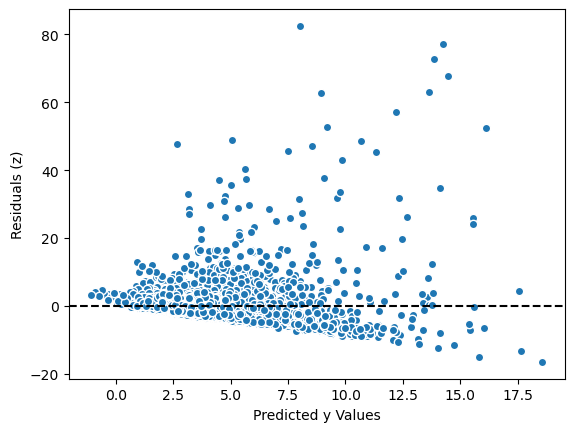

In [75]:
#m1.u is actual residuals, not standardised 
plt.plot(m1.predy, 
         m1.u, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Residuals (z)') 

In [76]:
m1_moran = esda.moran.Moran(m1.u, wKNN8)
print(round(m1_moran.I,3))
print(round(m1_moran.p_sim,3))

0.2
0.001


In [77]:
## 2021 correlation between property crime rate and all variables (OLS)
variable_names = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

m2 = spreg.OLS(
    gdf[['Property_1']].values, 
               gdf[variable_names].values,
               name_y='21_Property_crime_rate',
               name_x=variable_names)
print(m2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :21_Property_crime_rate                Number of Observations:        4647
Mean dependent var  :      2.2201                Number of Variables   :           7
S.D. dependent var  :      2.4753                Degrees of Freedom    :        4640
R-squared           :      0.0112
Adjusted R-squared  :      0.0100
Sum squared residual:     28146.3                F-statistic           :      8.7917
Sigma-square        :       6.066                Prob(F-statistic)     :   1.496e-09
S.E. of regression  :       2.463                Log likelihood        :  -10778.882
Sigma-square ML     :       6.057                Akaike info criterion :   21571.763
S.E of regression ML:      2.4611                Schwarz criterion     :   21616.871

--------------------------------------------------

Text(0, 0.5, 'Residuals (z)')

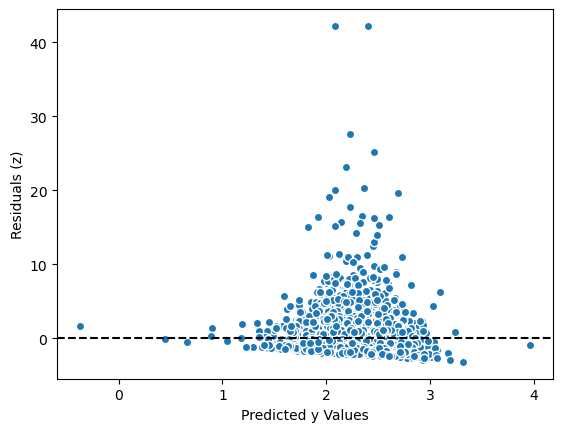

In [78]:
#m2.u is actual residuals, not standardised 
plt.plot(m2.predy, 
         m2.u, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Residuals (z)')

In [79]:
m2_moran = esda.moran.Moran(m2.u, wKNN8)
print(round(m2_moran.I,3))
print(round(m2_moran.p_sim,3))

0.191
0.001


##  AntiSocial Crime Rate

In [80]:
#2011 Global Moran's I for antisocial crime rate
moran = esda.moran.Moran(gdf['antiCrime_'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.278
0.001


In [81]:
#2021 Global Moran's I for antisocial crime rate
moran = esda.moran.Moran(gdf['antiCrim_1'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.118
0.001


In [82]:
## 2011 correlation between antisocial crime rate and all variables (OLS)
variable_names = ['unem_r_11','15-24_p_11','m_ratio_11','lpopden_11','2011_e_den','lowed_11']

m1 = spreg.OLS(
    gdf[['antiCrime_']].values, 
               gdf[variable_names].values,
               name_y='Antisocial_crime_r_11',
               name_x=variable_names)
print(m1.summary)

m2_moran = esda.moran.Moran(m1.u, wKNN8)
print(round(m2_moran.I,3))
print(round(m2_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Antisocial_crime_r_11                Number of Observations:        4647
Mean dependent var  :      1.1255                Number of Variables   :           7
S.D. dependent var  :      1.3241                Degrees of Freedom    :        4640
R-squared           :      0.1662
Adjusted R-squared  :      0.1651
Sum squared residual:     6791.72                F-statistic           :    154.1607
Sigma-square        :       1.464                Prob(F-statistic)     :   5.28e-179
S.E. of regression  :       1.210                Log likelihood        :   -7475.536
Sigma-square ML     :       1.462                Akaike info criterion :   14965.073
S.E of regression ML:      1.2089                Schwarz criterion     :   15010.180

---------------------------------------------------

In [83]:
## 2011 correlation between antisocial crime rate and all variables (Spatial Regression)
variable_names_11 = ['unem_r_11','15-24_p_11','m_ratio_11','lpopden_11','2011_e_den','lowed_11']

p_11__lagm = spreg.ML_Lag(gdf[['antiCrime_']].values,
                  gdf[variable_names_11].values,
                  w=wKNN8,
                  name_y='Antisocial_crime_r_11',
                  name_x=variable_names_11)
print(p_11__lagm.summary)

p_11__lagm_moran = esda.moran.Moran(p_11__lagm.u, wKNN8)
print(round(p_11__lagm_moran.I,3))
print(round(p_11__lagm_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Antisocial_crime_r_11                Number of Observations:        4647
Mean dependent var  :      1.1255                Number of Variables   :           8
S.D. dependent var  :      1.3241                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.2862
Spatial Pseudo R-squared:  0.1571
Log likelihood      :  -7211.3088
Sigma-square ML     :      1.2583                Akaike info criterion :   14438.618
S.E of regression   :      1.1217                Schwarz criterion     :   14490.169

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------

In [84]:
## 2021 correlation between antisocial crime rate and all variables (OLS)
variable_names = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

m1 = spreg.OLS(
    gdf[['antiCrim_1']].values, 
               gdf[variable_names].values,
               name_y='Antisocial_crime_r_21',
               name_x=variable_names)
print(m1.summary)

m2_moran = esda.moran.Moran(m1.u, wKNN8)
print(round(m2_moran.I,3))
print(round(m2_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Antisocial_crime_r_21                Number of Observations:        4647
Mean dependent var  :      3.1643                Number of Variables   :           7
S.D. dependent var  :      6.1593                Degrees of Freedom    :        4640
R-squared           :      0.0083
Adjusted R-squared  :      0.0070
Sum squared residual:      174793                F-statistic           :      6.4758
Sigma-square        :      37.671                Prob(F-statistic)     :    8.16e-07
S.E. of regression  :       6.138                Log likelihood        :  -15022.021
Sigma-square ML     :      37.614                Akaike info criterion :   30058.042
S.E of regression ML:      6.1330                Schwarz criterion     :   30103.150

---------------------------------------------------

In [85]:
## 2021 correlation between antisocial crime rate and all variables (Spatial Regression)
variable_names_11 = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

p_11__lagm = spreg.ML_Lag(gdf[['antiCrim_1']].values,
                  gdf[variable_names_11].values,
                  w=wKNN8,
                  name_y='Antisocial_crime_r_21',
                  name_x=variable_names_11)
print(p_11__lagm.summary)

p_11__lagm_moran = esda.moran.Moran(p_11__lagm.u, wKNN8)
print(round(p_11__lagm_moran.I,3))
print(round(p_11__lagm_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Antisocial_crime_r_21                Number of Observations:        4647
Mean dependent var  :      3.1643                Number of Variables   :           8
S.D. dependent var  :      6.1593                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.0671
Spatial Pseudo R-squared:  0.0101
Log likelihood      : -14928.6808
Sigma-square ML     :     35.6265                Akaike info criterion :   29873.362
S.E of regression   :      5.9688                Schwarz criterion     :   29924.913

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------

## Violent Crime Rate

In [86]:
#2011 Global Moran's I for Voilent crime rate
moran = esda.moran.Moran(gdf['ViolentCri'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.251
0.001


In [87]:
#2021 Global Moran's I for Voilent crime rate
moran = esda.moran.Moran(gdf['ViolentC_1'], wKNN8)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.18
0.001


In [88]:
## 2011 correlation between Voilent crime rate and all variables (OLS)
variable_names = ['unem_r_11','15-24_p_11','m_ratio_11','lpopden_11','2011_e_den','lowed_11']

m1 = spreg.OLS(
    gdf[['ViolentCri']].values, 
               gdf[variable_names].values,
               name_y='Violent_crime_r_11',
               name_x=variable_names)
print(m1.summary)

m2_moran = esda.moran.Moran(m1.u, wKNN8)
print(round(m2_moran.I,3))
print(round(m2_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Violent_crime_r_11                Number of Observations:        4647
Mean dependent var  :      1.7418                Number of Variables   :           7
S.D. dependent var  :      1.3983                Degrees of Freedom    :        4640
R-squared           :      0.2017
Adjusted R-squared  :      0.2006
Sum squared residual:      7251.9                F-statistic           :    195.3392
Sigma-square        :       1.563                Prob(F-statistic)     :  1.322e-222
S.E. of regression  :       1.250                Log likelihood        :   -7627.862
Sigma-square ML     :       1.561                Akaike info criterion :   15269.724
S.E of regression ML:      1.2492                Schwarz criterion     :   15314.832

------------------------------------------------------

In [89]:
## 2011 correlation between antisocial crime rate and all variables (Spatial Regression)
variable_names_11 = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

p_11__lagm = spreg.ML_Lag(gdf[['ViolentCri']].values,
                  gdf[variable_names_11].values,
                  w=wKNN8,
                  name_y='Violent_crime_r_21',
                  name_x=variable_names_11)
print(p_11__lagm.summary)

p_11__lagm_moran = esda.moran.Moran(p_11__lagm.u, wKNN8)
print(round(p_11__lagm_moran.I,3))
print(round(p_11__lagm_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Violent_crime_r_21                Number of Observations:        4647
Mean dependent var  :      1.7418                Number of Variables   :           8
S.D. dependent var  :      1.3983                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.2588
Spatial Pseudo R-squared:  0.1750
Log likelihood      :  -7525.1586
Sigma-square ML     :      1.4535                Akaike info criterion :   15066.317
S.E of regression   :      1.2056                Schwarz criterion     :   15117.869

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------

In [90]:
## 2021 correlation between Voilent crime rate and all variables (OLS)
variable_names = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

m1 = spreg.OLS(
    gdf[['ViolentC_1']].values, 
               gdf[variable_names].values,
               name_y='Violent_crime_r_21',
               name_x=variable_names)
print(m1.summary)

m2_moran = esda.moran.Moran(m1.u, wKNN8)
print(round(m2_moran.I,3))
print(round(m2_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Violent_crime_r_21                Number of Observations:        4647
Mean dependent var  :      1.7241                Number of Variables   :           7
S.D. dependent var  :      2.1626                Degrees of Freedom    :        4640
R-squared           :      0.0274
Adjusted R-squared  :      0.0262
Sum squared residual:     21132.1                F-statistic           :     21.8186
Sigma-square        :       4.554                Prob(F-statistic)     :   1.937e-25
S.E. of regression  :       2.134                Log likelihood        :  -10112.913
Sigma-square ML     :       4.547                Akaike info criterion :   20239.825
S.E of regression ML:      2.1325                Schwarz criterion     :   20284.933

------------------------------------------------------

In [91]:
## 2021 correlation between antisocial crime rate and all variables (Spatial Regression)
variable_names_11 = ['unem_r_21','15-24_p_21','m_ratio_21','lpopden_21','2021_e_den','lowed_21']

p_11__lagm = spreg.ML_Lag(gdf[['ViolentC_1']].values,
                  gdf[variable_names_11].values,
                  w=wKNN8,
                  name_y='Violent_crime_r_21',
                  name_x=variable_names_11)
print(p_11__lagm.summary)

p_11__lagm_moran = esda.moran.Moran(p_11__lagm.u, wKNN8)
print(round(p_11__lagm_moran.I,3))
print(round(p_11__lagm_moran.p_sim,3))

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Violent_crime_r_21                Number of Observations:        4647
Mean dependent var  :      1.7241                Number of Variables   :           8
S.D. dependent var  :      2.1626                Degrees of Freedom    :        4639
Pseudo R-squared    :      0.1321
Spatial Pseudo R-squared:  0.0337
Log likelihood      :  -9928.0544
Sigma-square ML     :      4.0960                Akaike info criterion :   19872.109
S.E of regression   :      2.0239                Schwarz criterion     :   19923.661

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------

## Spatial Pattern of Crime Rates in London

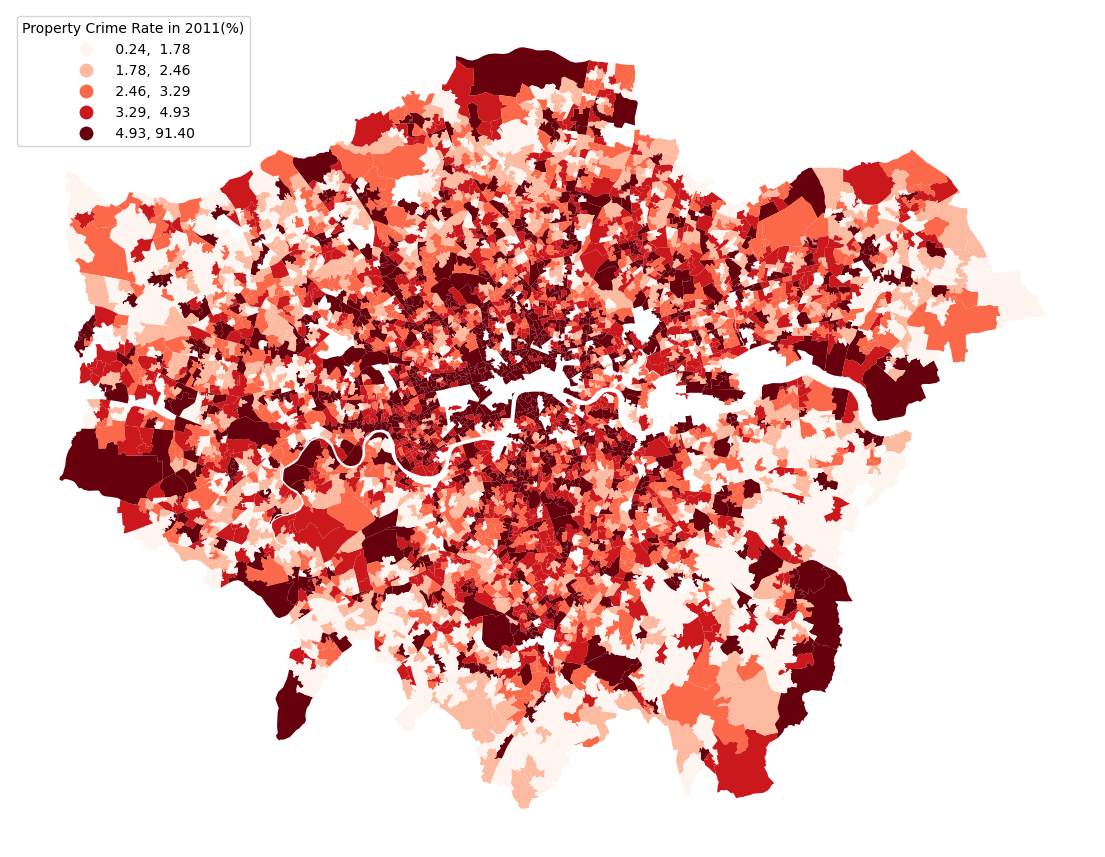

In [92]:
#spatial distribution in 2011
fig, ax = plt.subplots(1, figsize=(14, 14))
gdf.plot(column='PropertyCr', cmap='Reds',
scheme='quantiles', k=5,
linewidth=0.,
legend=True, legend_kwds={"title":"Property Crime Rate in 2011(%)","loc": 2},
ax=ax)
ax.set_axis_off()
plt.savefig('gdp_plot_2011.png')

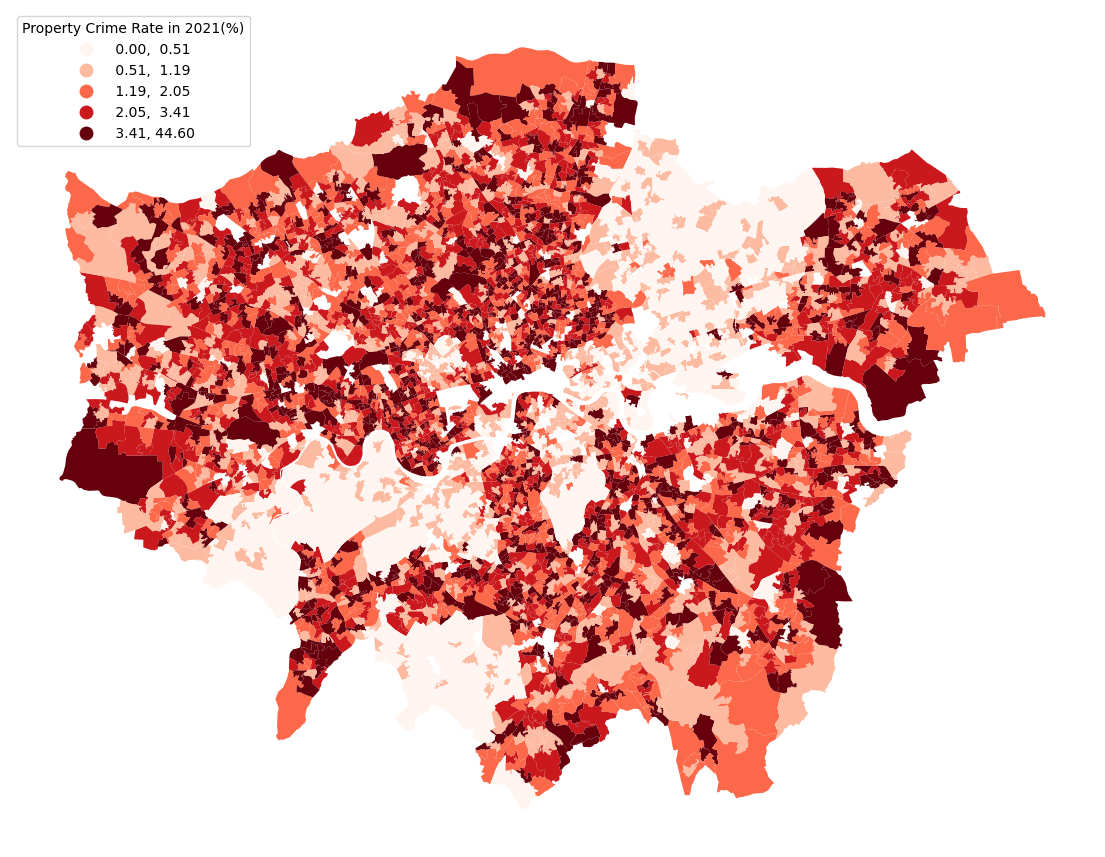

In [93]:
#spatial distribution in 2021
fig, ax = plt.subplots(1, figsize=(14, 14))
gdf.plot(column='Property_1', cmap='Reds',
scheme='quantiles', k=5,
linewidth=0.,
legend=True, legend_kwds={"title":"Property Crime Rate in 2021(%)","loc": 2},
ax=ax)
ax.set_axis_off()
plt.savefig('gdp_plot_2021.png')

In [94]:
zero_count = (gdf['PropertyCr'] > 4.91).sum()
zero_count

934

In [95]:
zero_count = (gdf['Property_1'] > 3.41).sum()
zero_count

933

In [96]:
count_between_range = ((gdf['Property_1'] >= 0) & (gdf['Property_1'] <= 0.51)).sum()
count_between_range

921

In [97]:
#Moran's I in 2011
w = weights.KNN.from_dataframe(gdf, k=8)
w.transform = 'R'
moran = esda.moran.Moran(gdf['PropertyCr'], w)
round(moran.I,3)

0.262

In [98]:
moran.p_sim

0.001

In [99]:
#Moran's I in 2021
w = weights.KNN.from_dataframe(gdf, k=8)
w.transform = 'R'
moran_21 = esda.moran.Moran(gdf['all_crim_1'], w)
round(moran_21.I,3)

0.262

In [100]:
moran_21.p_sim

0.001

## Moran Plot

In [101]:
gdf['crime_rate_lag_11'] = weights.spatial_lag.lag_spatial(w, gdf['all_crime_'])
gdf['crime_rate_lag_21'] = weights.spatial_lag.lag_spatial(w, gdf['all_crim_1'])

In [102]:
def standardize(df, var):
    name = var + '_z'
    df[name] = (df[var] - df[var].mean()) / df[var].std()

standardize(gdf,'all_crime_')
standardize(gdf,'all_crim_1')
standardize(gdf,'crime_rate_lag_11')
standardize(gdf,'crime_rate_lag_21')

In [103]:
gdf.head()

LSOA21CD                   LSOA21NM   MSOA21CD                  MSOA21NM  \
0  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   
1  E01000007  Barking and Dagenham 015A  E02000016  Barking and Dagenham 015   
2  E01000008  Barking and Dagenham 015B  E02000016  Barking and Dagenham 015   
3  E01000009  Barking and Dagenham 016B  E02000017  Barking and Dagenham 016   
4  E01000011  Barking and Dagenham 016C  E02000017  Barking and Dagenham 016   

     LAD22CD               LAD22NM  LSOA21KM2  LSOAP21 CHGIND  TotRes21  \
0  E09000002  Barking and Dagenham    0.14654      1.0      U      1845   
1  E09000002  Barking and Dagenham    0.20009      1.0      U      2908   
2  E09000002  Barking and Dagenham    0.19365      1.0      U      1795   
3  E09000002  Barking and Dagenham    0.12796      1.0      U      1804   
4  E09000002  Barking and Dagenham    0.09163      1.0      U      1701   

   TotRes11_m  TotHHolds2  TotHHolds1  FemRes21  FemRes11_m  MalRes21  \
0        1703         554         543       902         837       943   
1        1391        1191         612      1461         684      1447   
2        1544         548         521       948         727       847   
3        1773         601         638       856         774       949   
4        1634         473         457       789         709       912   

   MalRes11_m  Asian21  Asian11_m2  Black21  Black11_m2  MixedE21  MixedE11_m  \
0         866      885         861      200         177        70          58   
1         707      929         447      828         389       183          88   
2         817      460         349      716         574        87          83   
3         999      884        1012      202         228        53          62   
4         925      934        1070      172         143        41          28   

   White21  White11_m2  OtherE21  OtherE11_m  CarsZero21  CarsZero11  \
0      605         557        85          50         183         186   
1      837         439       129          28         726         385   
2      449         485        84          53         281         305   
3      548         422       118          49         303         336   
4      483         346        74          47         217         186   

   CarsOne21  CarsOne11_  CarsTwo21  CarsTwo11_  CarsThrp21  CarsThrp11  \
0        251         249         95          87          25          14   
1        408         185         50          38           7           3   
2        205         174         50          34          11           4   
3        215         237         57          50          25          12   
4        173         188         67          69          17          13   

   EconEm21  EconEm11_m  EconUn21  EconUn11_m  EconSt21  EconSt11_m  EconRe21  \
0       842         733        57         168       156         175       117   
1      1254         548       154         191       297         210        62   
2       614         480        67         238       227         201        53   
3       740         701        82         182       150         234       132   
4       703         609        68         161       182         249       123   

   EconRe11_m  EconOt21  EconOt11_m  AgeChild21  AgeChild11  AgeAdult21  \
0          72       256         188         414         394        1270   
1          34       391         155         748         333        2084   
2          28       300         189         537         502        1193   
3         110       304         241         396         311        1242   
4          69       244         228         382         365        1189   

   AgeAdult11  AgeSenior2  AgeSenior1  HealthVG21  HealthVG11  HealthGood  \
0        1176         158         133         880         886         679   
1        1000          72          58        1632         699         930   
2        1002          61          40         947         788         571   
3        1281   

In [104]:
#2011
def rules(row):
    if row['all_crime__z'] > 0:
        if row['crime_rate_lag_11_z'] > 0:
            return 'HH'
        else:
            return 'HL'
    else:
        if row['crime_rate_lag_11_z'] > 0:
            return 'LH'
        else:
            return 'LL'

gdf['quadrant_11'] = gdf.apply(rules, 1)

<Axes: >

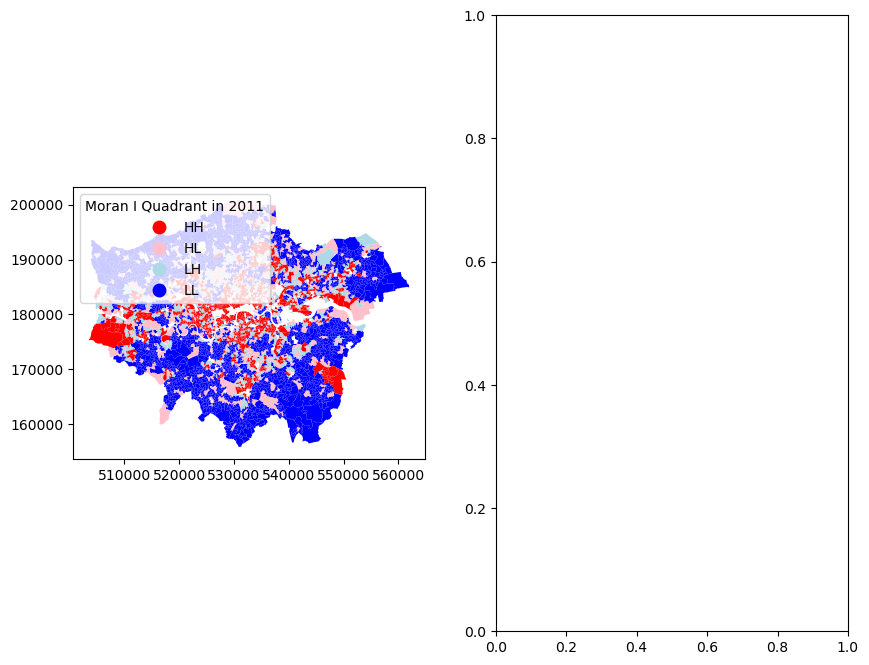

In [105]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

qcolors = {'HH':'red', 'HL':'pink', 'LH':'lightblue', 'LL':'blue'}

#map
gdf.plot(column='quadrant_11', categorical=True, cmap=colors.ListedColormap(qcolors.values()),
         k=2, edgecolor='white', linewidth=0.0,
         legend=True, legend_kwds={"title":'Moran I Quadrant in 2011',"loc": 2},
         ax=ax[0])


In [106]:
#scatter plot
ax[1].scatter(gdf['all_crime__z'], gdf['crime_rate_lag_11_z'], c=gdf['quadrant_11'].map(qcolors))
ax[1].axvline(0, c='k', alpha=0.5)
ax[1].axhline(0, c='k', alpha=0.5)
ax[1].set_xlabel("Vote Leave % (z)")
ax[1].set_ylabel("Local Mean crime rate in 2011% (z)")

plt.show()

In [107]:
#2021
def rules(row):
    if row['all_crim_1_z'] > 0:
        if row['crime_rate_lag_21_z'] > 0:
            return 'HH'
        else:
            return 'HL'
    else:
        if row['crime_rate_lag_21_z'] > 0:
            return 'LH'
        else:
            return 'LL'

gdf['quadrant_21'] = gdf.apply(rules, 1)

## Local Moran's I 

In [108]:
# 2011
lisa2011 = esda.moran.Moran_Local(gdf['PropertyCr'], w)

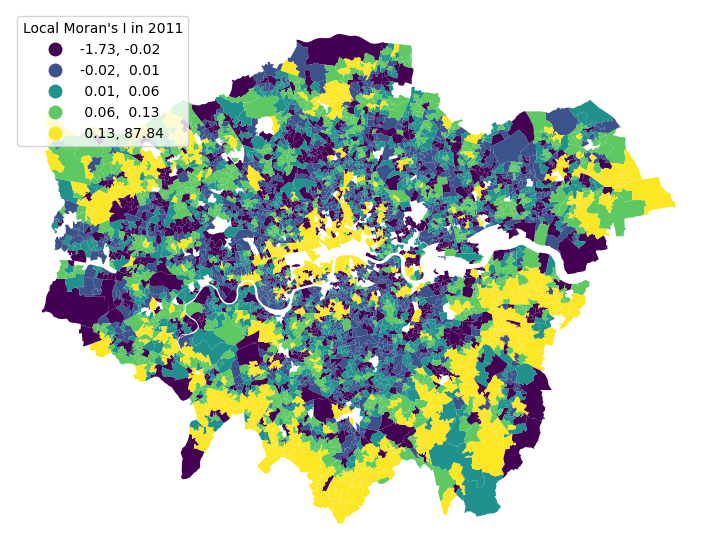

In [109]:
gdf['Is'] = lisa2011.Is
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Is', cmap='viridis',
scheme='quantiles', k=5,
linewidth=0.,
legend=True, legend_kwds={"title":"Local Moran's I in 2011","loc": 2},
ax=ax
)
ax.set_axis_off()

In [110]:
gdf['p-sim_11'] = lisa2011.p_sim
sig_11 = 1 * (lisa2011.p_sim < 0.05)
slabels11 = ['non-sig.', 'significant']
labels11 = [slabels11[i] for i in sig_11]
gdf['sig_11'] = labels11
gdf[['sig_11','p-sim_11']].head(10)

sig_11  p-sim_11
0  non-sig.     0.490
1  non-sig.     0.362
2  non-sig.     0.494
3  non-sig.     0.491
4  non-sig.     0.302
5  non-sig.     0.447
6  non-sig.     0.407
7  non-sig.     0.444
8  non-sig.     0.236
9  non-sig.     0.392

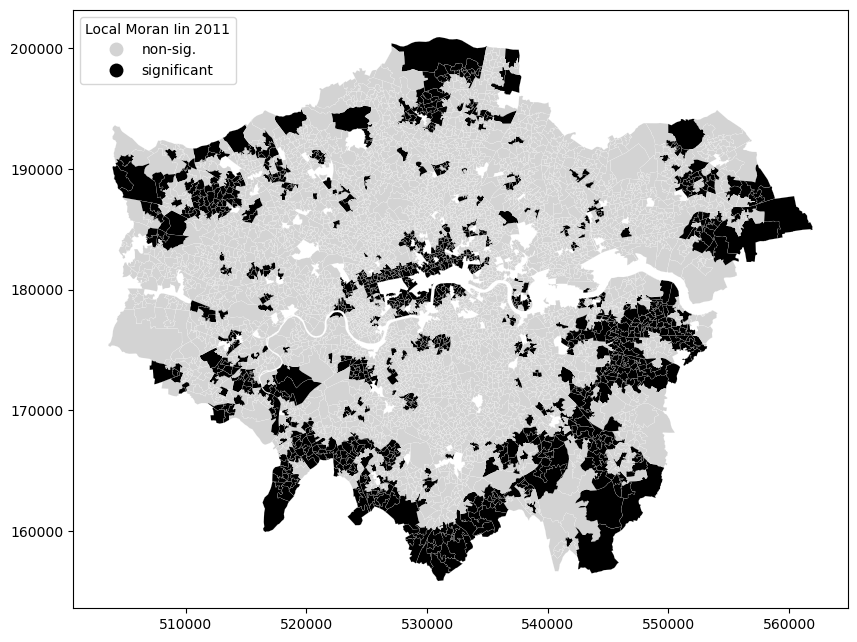

In [111]:
fig, ax = plt.subplots(1,figsize=(10,8))
sigcolors = {'non-sig.':'lightgrey', 'significant':'black'}
gdf.plot(column='sig_11', categorical=True, cmap=colors.ListedColormap(sigcolors.
values()),
k=2, linewidth=0.1, edgecolor='white',
legend=True, legend_kwds={"title":'Local Moran Iin 2011',"loc": 2},
ax=ax)
plt.show()

In [112]:
lisa2011.q[1:10]

array([4, 3, 4, 2, 3, 4, 3, 2, 3])

In [113]:
counts11 = [(j,(lisa2011.q==j).sum()) for j in range(1,5)]
counts11

[(1, 607), (2, 792), (3, 2650), (4, 598)]

In [114]:
qlabels11 = ['HH', 'LH', 'LL', 'HL'] #pysal scheme is HH=1, LH=2, LL=3, HL=4
labels11 = [qlabels11[i-1] for i in lisa2011.q] #list substituting 1-4 with HH-HL
labels11[1:10]

['HL', 'LL', 'HL', 'LH', 'LL', 'HL', 'LL', 'LH', 'LL']

In [115]:
gdf['qlabels11'] = labels11
[(qlabel11, (gdf['qlabels11']==qlabel11).sum()) for qlabel11 in qlabels11]

[('HH', 607), ('LH', 792), ('LL', 2650), ('HL', 598)]

In [116]:
hotspot = 1 * (sig_11 * lisa2011.q==1)
coldspot = 3 * (sig_11 * lisa2011.q==3)
doughnut = 2 * (sig_11 * lisa2011.q==2)
diamond = 4 * (sig_11 * lisa2011.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 non-sig.', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels11 = [spot_labels[i] for i in spots]

In [117]:
gdf['slabels11'] = labels11
[(spot_label, (gdf['slabels11']==spot_label).sum()) for spot_label in spot_labels]

[('0 non-sig.', 3581),
 ('1 hot spot', 217),
 ('2 doughnut', 107),
 ('3 cold spot', 669),
 ('4 diamond', 73)]

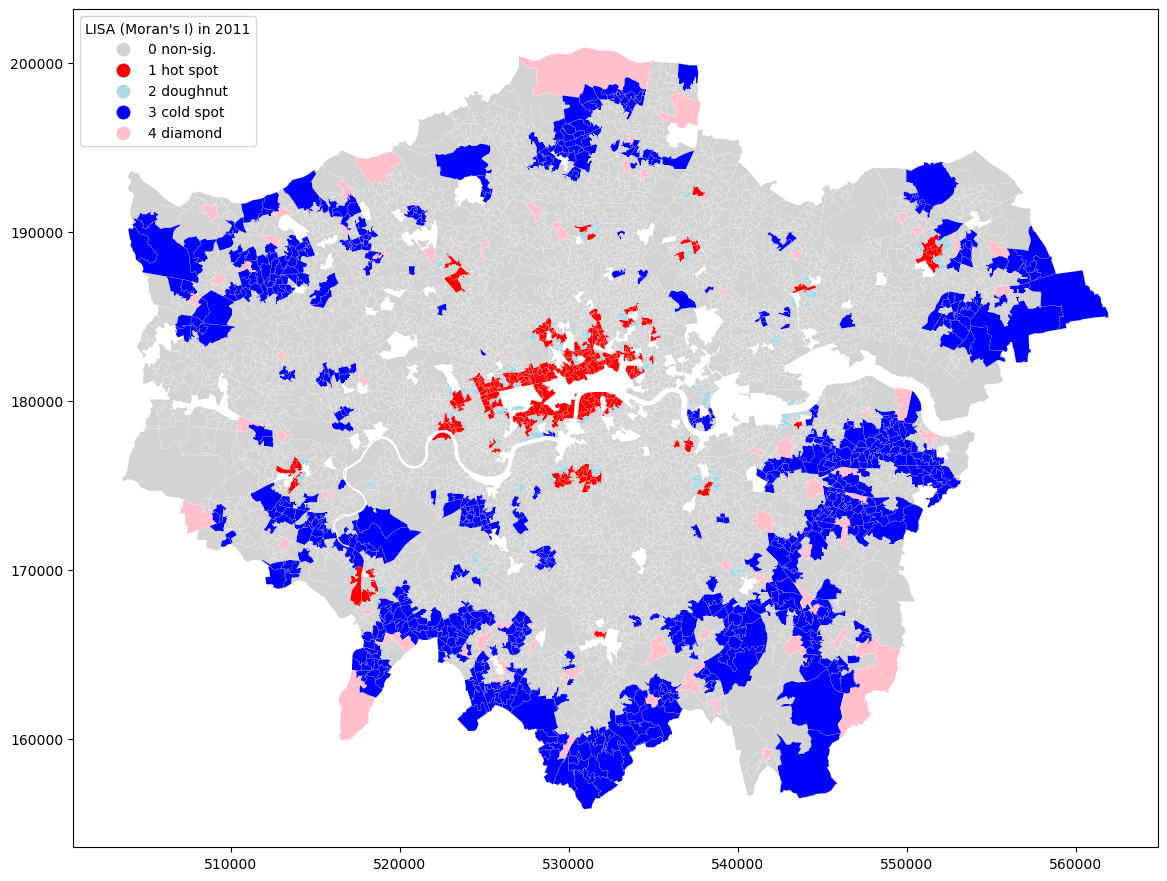

In [118]:
fig, ax = plt.subplots(1, figsize=(14,14))
sigcolors = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue','pink'])
gdf.plot(column='slabels11', categorical=True,
k=2, cmap=sigcolors, linewidth=0.1, edgecolor='white',
legend=True, legend_kwds={"title":"LISA (Moran's I) in 2011","loc": 2},
ax=ax)
plt.show()
fig.savefig('Moran I in 2011', dpi = 300, bbox_inches = 'tight', facecolor = 'white')

In [119]:
# 2021
lisa2021 = esda.moran.Moran_Local(gdf['all_crim_1'], w)

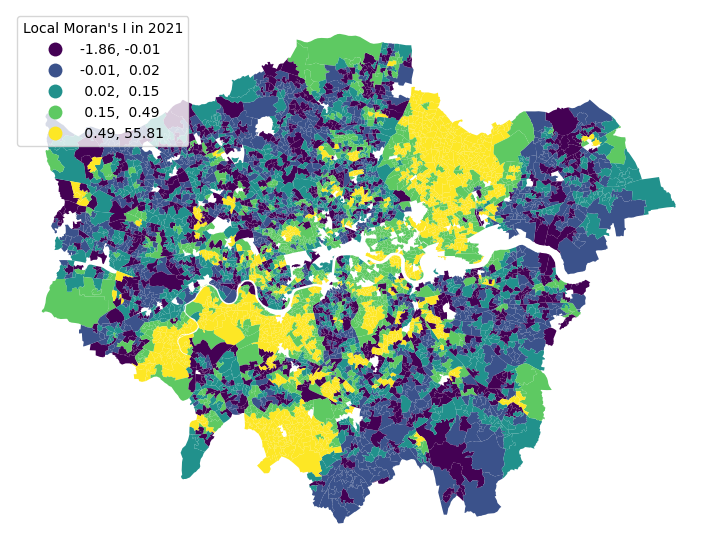

In [120]:
gdf['Is_1'] = lisa2021.Is
fig, ax = plt.subplots(1, figsize=(9, 9))
gdf.plot(column='Is_1', cmap='viridis',
scheme='quantiles', k=5,
linewidth=0.,
legend=True, legend_kwds={"title":"Local Moran's I in 2021","loc": 2},
ax=ax
)
ax.set_axis_off()

In [121]:
gdf['p-sim_21'] = lisa2021.p_sim
sig_21 = 1 * (lisa2021.p_sim < 0.05)
slabels21 = ['non-sig.', 'significant']
labels21 = [slabels21[i] for i in sig_21]
gdf['sig_21'] = labels21
gdf[['sig_21','p-sim_21']].head(10)

sig_21  p-sim_21
0  significant     0.012
1  significant     0.018
2  significant     0.015
3  significant     0.032
4  significant     0.029
5     non-sig.     0.351
6     non-sig.     0.223
7     non-sig.     0.358
8     non-sig.     0.165
9     non-sig.     0.327

In [122]:
lisa2021.q[1:10]

array([1, 4, 1, 1, 4, 1, 1, 2, 2])

In [123]:
counts21 = [(j,(lisa2021.q==j).sum()) for j in range(1,5)]
counts21

[(1, 1565), (2, 883), (3, 1807), (4, 392)]

In [124]:
qlabels21 = ['HH', 'LH', 'LL', 'HL'] #pysal scheme is HH=1, LH=2, LL=3, HL=4
labels21 = [qlabels21[i-1] for i in lisa2021.q] #list substituting 1-4 with HH-HL
labels21[1:10]

['HH', 'HL', 'HH', 'HH', 'HL', 'HH', 'HH', 'LH', 'LH']

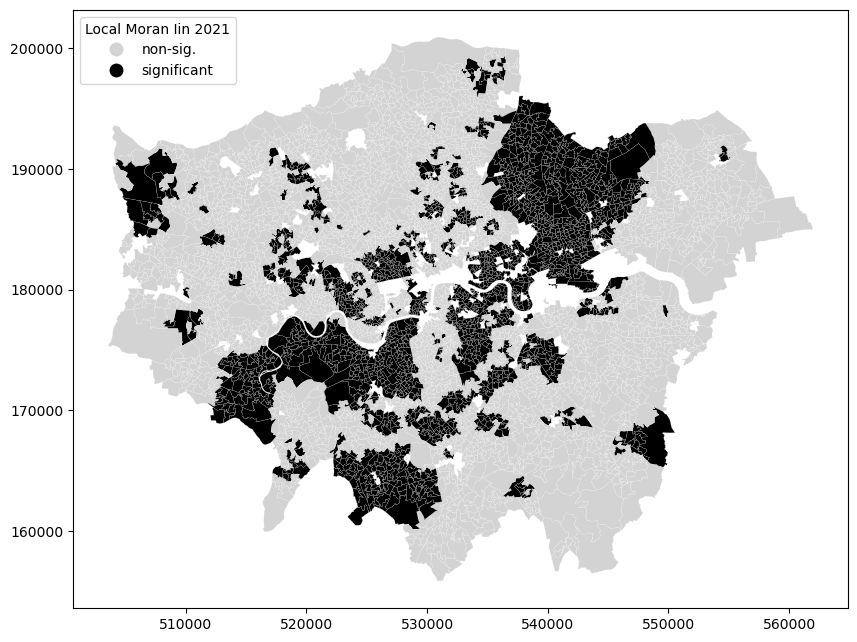

In [125]:
fig, ax = plt.subplots(1,figsize=(10,8))
sigcolors = {'non-sig.':'lightgrey', 'significant':'black'}
gdf.plot(column='sig_21', categorical=True, cmap=colors.ListedColormap(sigcolors.
values()),
k=2, linewidth=0.1, edgecolor='white',
legend=True, legend_kwds={"title":'Local Moran Iin 2021',"loc": 2},
ax=ax)
plt.show()

In [126]:
gdf['qlabels21'] = labels21
[(qlabel21, (gdf['qlabels21']==qlabel21).sum()) for qlabel21 in qlabels21]

[('HH', 1565), ('LH', 883), ('LL', 1807), ('HL', 392)]

In [127]:
hotspot = 1 * (sig_21 * lisa2021.q==1)
coldspot = 3 * (sig_21 * lisa2021.q==3)
doughnut = 2 * (sig_21 * lisa2021.q==2)
diamond = 4 * (sig_21 * lisa2021.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 non-sig.', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels21 = [spot_labels[i] for i in spots]

In [128]:
gdf['slabels21'] = labels21
[(spot_label, (gdf['slabels21']==spot_label).sum()) for spot_label in spot_labels]

[('0 non-sig.', 2885),
 ('1 hot spot', 425),
 ('2 doughnut', 138),
 ('3 cold spot', 1185),
 ('4 diamond', 14)]

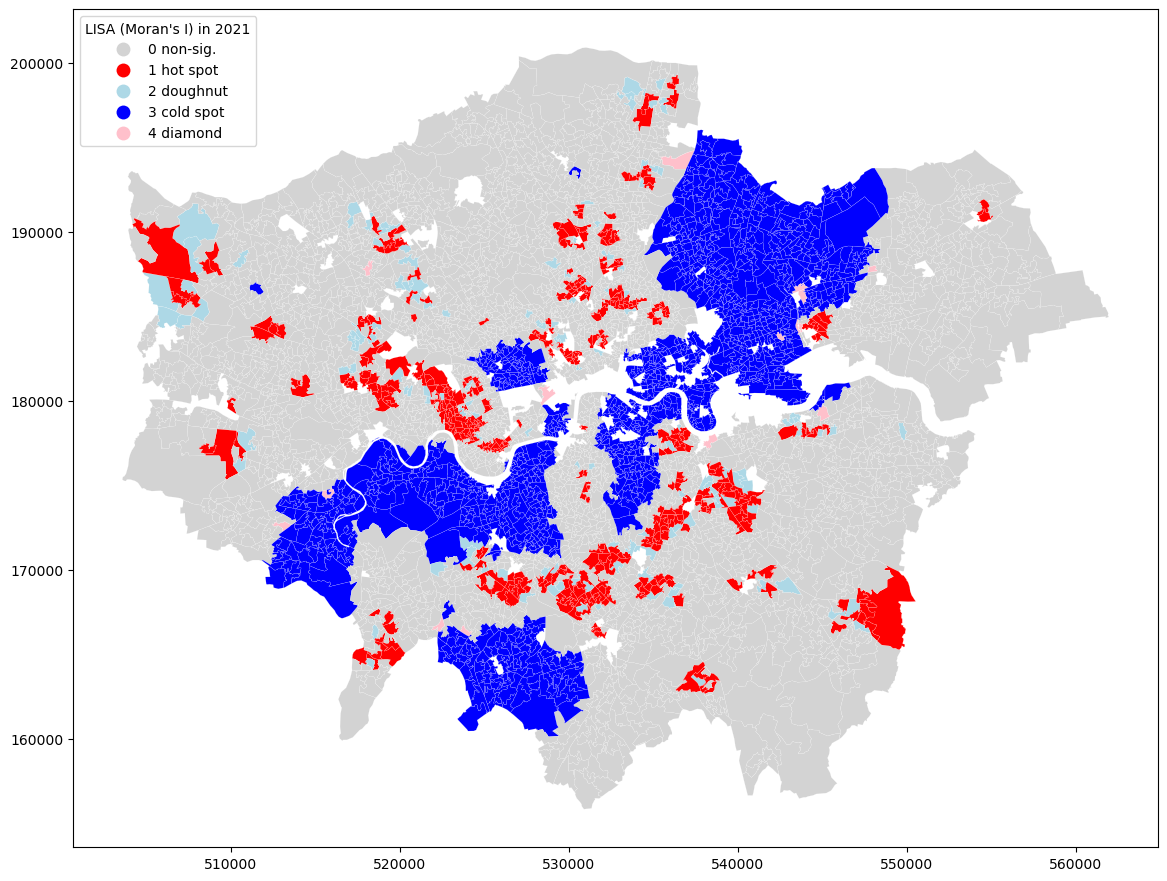

In [129]:
fig, ax = plt.subplots(1, figsize=(14,14))
sigcolors = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue','pink'])
gdf.plot(column='slabels21', categorical=True,
k=2, cmap=sigcolors, linewidth=0.1, edgecolor='white',
legend=True, legend_kwds={"title":"LISA (Moran's I) in 2021","loc": 2},
ax=ax)
plt.show()
fig.savefig('Moran I in 2021', dpi = 300, bbox_inches = 'tight', facecolor = 'white')